In [1]:
import os
import re
import glob
import feather
import numpy as np
import pandas as pd
import unicodedata
import matplotlib.pyplot as plt
from itertools import product
from functools import partial
from pathlib import Path

# dask
import dask
import dask.dataframe as dd
from dask.distributed import Client


from src.clean_data import clean_rfc_fantasma, clean_sancionados, clean_rupc

# # features generales
# from src.features_general import (
#     monto_por_unidad_compradora,
#     proveedores_distintos,
#     procedimientos_distintos,
#     numero_de_contratos,
# )

# # features competencia
# from src.features_competencia import (
#     contratos_por_proveedor,
#     porcentaje_procedimientos_por_tipo,
#     porcentaje_monto_tipo_procedimiento,
#     importe_promedio_por_contrato,
#     calcular_IHH_ID_contratos,
#     calcular_IHH_ID_monto,
#     tendencia_adjudicacion_directa,
# )

# # features transparencia
# from src.features_transparencia import (
#     # procedimientos
#     porcentaje_procedimientos_presenciales,
#     contratos_promedio_por_procedimimento,
#     contratos_por_duracion,
#     monto_por_duracion,
#     promedio_datos_faltantes_poc_contrato,
#     # scraper
#     porcentaje_procs_sin_contrato,
#     porcentaje_procs_sin_fallo,
#     porcentaje_procs_sin_apertura,
#     porcentaje_procedimientos_sin_archivos,
#     promedio_procs_por_archivo,
#     #tendencia_publicacion_contratos,
# )

# # features anomalias
# from src.features_anomalias import (
#     # procedimientos
#     interaccion_rfc_fantasma,
#     interaccion_sancionados,
#     porcentaje_contratos_por_convenio,
#     pc_licitaciones_nacionales_menor_15_dias,
#     pc_licitaciones_internacionales_menor_20_dias,
#     pc_licitaciones_internacionales_menor_40_dias,
#     diferente_estratificacion,
#     porcentaje_adjudicaciones_excedieron_monto,
#     # scraper
#     promedio_convenios_por_proc,
#     porcentaje_procs_sin_junta_aclaracion,
#     porcentaje_procs_sin_convocatoria,
#     porcentaje_adjudicaciones_incompletas,
#     porcentaje_invitaciones_incompletas,
#     porcentaje_licitaciones_incompletas,
# )


pd.set_option('display.max_rows', 100)
pd.set_option('display.max_columns', 100)

%matplotlib inline
%config IPCompleter.use_jedi = False

## Cargar tabla procedimientos

In [2]:
df_procedimientos = feather.read_dataframe(
    '../data/bases/procedimientos_all_2017_10_29.feather', nthreads=7)
print(df_procedimientos.shape)
df_procedimientos = df_procedimientos.loc[df_procedimientos.GOBIERNO == 'APF', :]
df_procedimientos = df_procedimientos.drop('GOBIERNO', axis=1)
df_procedimientos = df_procedimientos.assign(CLAVEUC=df_procedimientos.CLAVEUC_REAL)
df_procedimientos = df_procedimientos.drop('CLAVEUC_REAL', axis=1)
df_procedimientos = df_procedimientos.loc[~df_procedimientos.PROVEEDOR_CONTRATISTA.isnull()]
print(df_procedimientos.shape)
df_procedimientos = df_procedimientos.loc[df_procedimientos.CLAVEUC != 'MISSING']

# Rellenar el caracter faltante
caracter = df_procedimientos.CARACTER.mask(df_procedimientos.CARACTER == '').fillna('SIN REPORTAR')
df_procedimientos = df_procedimientos.assign(CARACTER=caracter)

mapa_codigos_caracter = {'N': 'NACIONAL', 'I': 'INTERNACIONAL', 'T': 'INTERNACIONAL BAJO TLC'}

codigos_caracter = df_procedimientos.loc[df_procedimientos.CARACTER == 'SIN REPORTAR'].NUMERO_PROCEDIMIENTO.map(
    lambda x: x.split('-')[2][0] if isinstance(x, str) else x
)
codigos_caracter = codigos_caracter.map(lambda x: mapa_codigos_caracter.get(x, 'SIN REPORTAR'))

df_procedimientos.loc[df_procedimientos.CARACTER == 'SIN REPORTAR', 'CARACTER'] = codigos_caracter

del caracter
print(df_procedimientos.shape)
df_procedimientos.head()

(1014554, 47)
(884997, 45)
(884960, 45)


,DEPENDENCIA,SIGLAS,NOMBRE_DE_LA_UC,CLAVEUC,RESPONSABLE,ESTRATIFICACION_MUC,FOLIO_RUPC,PROVEEDOR_CONTRATISTA,ESTATUS_EMPRESA,ESTRATIFICACION_MPC,IMPORTE_CONTRATO,APORTACION_FEDERAL,MONEDA,NUMERO_PROCEDIMIENTO,FORMA_PROCEDIMIENTO,TIPO_PROCEDIMIENTO,CODIGO_CONTRATO,TITULO_CONTRATO,IDENTIFICADOR_CM,TIPO_CONTRATACION,ESTATUS_CONTRATO,COMPRA_CONSOLIDADA,PLURIANUAL,CARACTER,CONTRATO_MARCO,CONVENIO_MODIFICATORIO,PROC_F_PUBLICACION,FECHA_APERTURA_PROPOSICIONES,EXP_F_FALLO,FECHA_CELEBRACION,FECHA_INICIO,FECHA_FIN,CODIGO_EXPEDIENTE,TITULO_EXPEDIENTE,PLANTILLA_EXPEDIENTE,CLAVE_PROGRAMA,CUENTA_ADMINISTRADA_POR,ANUNCIO,ARCHIVADO,SIGLAS_PAIS,RAMO,ORGANISMO,C_EXTERNO,FECHA_ARCHIVO,IMPORTE_PESOS
70,AEROPUERTOS Y SERVICIOS AUXILIARES,ASA,ASA-ESTACION DE COMBUSTIBLES DEL AEROPUERTO DE...,009JZL032,JOSE LUIS ALMADA PENUNURI,MICRO,nan,MULTISERVICIOS Y ASESORIAS DEL CARIBE,HABILITADO,None,319200.0,NaN,MXN,IA-009JZL032-N1-2012,MIXTA,INVITACION A CUANDO MENOS TRES,165782,SERVICIO DE LIMPIEZA CZM 2012,None,ADQUISICIONES,EXPIRADO,0.0,0.0,NACIONAL,0.0,SI,NaT,2011-12-16 00:00:00,2011-12-19,NaT,2012-01-01,2013-02-28,115807,SERVICIO DE LIMPIEZA CZM 2012,Z15122015 04 INVITACION A CUANDO MENOS TRES NA...,None,UC,https://compranet.funcionpublica.gob.mx/esop/g...,Si,MX,NaN,None,NaN,2012,319200.0
71,AEROPUERTOS Y SERVICIOS AUXILIARES,ASA,ASA-ESTACION DE COMBUSTIBLES DEL AEROPUERTO DE...,009JZL032,JOSE LUIS ALMADA PENUNURI,MICRO,nan,ALEJANDRO ALARCON JIMON,HABILITADO,None,26097.0,NaN,MXN,AA-009JZL032-N4-2012,PRESENCIAL,ADJUDICACION DIRECTA,165738,MANTENIMIENTO A EXTINTORES CZM,None,SERVICIOS,EXPIRADO,0.0,0.0,NACIONAL,0.0,NO,2012-08-10 15:59:00,2012-08-10 16:05:00,NaT,2012-08-20,2012-08-26,2012-12-31,242370,SERVICIO DE MANTENIMIENTO A EXTINTORES AD CZM ...,Z15122015 07 ADJUDICACION DIRECTA NACIONAL ART...,None,UC,https://compranet.funcionpublica.gob.mx/esop/g...,Si,MX,NaN,None,NaN,2012,26097.0
72,AEROPUERTOS Y SERVICIOS AUXILIARES,ASA,ASA-ESTACION DE COMBUSTIBLES DEL AEROPUERTO DE...,009JZL032,JOSE LUIS ALMADA PENUNURI,MICRO,5578,TRANSPORTE ESPECIALIZADO DE PERSONAL NACIONAL,HABILITADO,MEDIANA,361200.0,NaN,MXN,IA-009JZL032-N2-2012,MIXTA,INVITACION A CUANDO MENOS TRES,148131,SERVICIO DE TRANSPORTE DE PERSONAL DE LA ESTAC...,None,SERVICIOS,EXPIRADO,0.0,0.0,NACIONAL,0.0,SI,2011-12-09 14:51:00,2011-12-16 14:00:00,2011-12-19,NaT,2012-01-01,2013-02-28,116667,SERVICIO DE TRANSPORTE DE PERSONAL CZM 2012,Z15122015 04 INVITACION A CUANDO MENOS TRES NA...,None,PoC,https://compranet.funcionpublica.gob.mx/esop/g...,Si,MX,NaN,None,NaN,2012,361200.0
73,AEROPUERTOS Y SERVICIOS AUXILIARES,ASA,ASA-ESTACION DE COMBUSTIBLES DEL AEROPUERTO DE...,009JZL032,JOSE LUIS ALMADA PENUNURI,MICRO,nan,COMERCIALIZADORA EL MAHARAJA,HABILITADO,None,334264.0,NaN,MXN,AA-009JZL032-N5-2011,MIXTA,ADJUDICACION DIRECTA,276283,SERVICIO DE COMEDOR DEL PERSONAL DE LA ESTACIO...,None,ADQUISICIONES,EXPIRADO,0.0,0.0,NACIONAL,0.0,SI,2011-12-28 12:45:00,2011-12-28 17:00:00,NaT,NaT,2012-01-01,2013-02-28,123933,SERVICIO DE COMEDOR AD CZM 2012,Z15122015 07 ADJUDICACION DIRECTA NACIONAL ART...,None,UC,https://compranet.funcionpublica.gob.mx/esop/g...,Si,MX,NaN,None,NaN,2012,334264.0
74,AEROPUERTOS Y SERVICIOS AUXILIARES,ASA,ASA-ESTACION DE COMBUSTIBLES DEL AEROPUERTO DE...,009JZL032,JOSE LUIS ALMADA PENUNURI,MEDIANA,nan,COMERCIALIZADORA EL MAHARAJA,HABILITADO,None,285948.0,NaN,MXN,AA-009JZL032-N5-2011,MIXTA,ADJUDICACION DIRECTA,148083,SERVICIO DE COMEDOR PARA EL PERSONAL DE LA EST...,None,SERVICIOS,EXPIRADO,0.0,0.0,NACIONAL,NaN,NO,2011-12-28 12:45:00,2011-12-28 17:00:00,NaT,2011-12-30,2012-01-01,2012-12-31,123933,SERVICIO DE COMEDOR AD CZM 2012,Z15122015 07 ADJUDICACION DIRECTA NACIONAL ART...,None,UC,https://compranet.funcionpublica.gob.mx/esop/g...,Si,MX,NaN,None,NaN,2012,285948.0


In [3]:
# df_contratos = df_procedimientos.groupby('NUMERO_PROCEDIMIENTO').CODIGO_CONTRATO.nunique().reset_index()
# # df_contratos.sort_values('CODIGO_CONTRATO', ascending=False)
# df_contratos.CODIGO_CONTRATO.sum()

In [3]:
df_procedimientos.loc[df_procedimientos.CLAVEUC == '007HXA999']

,DEPENDENCIA,SIGLAS,NOMBRE_DE_LA_UC,CLAVEUC,RESPONSABLE,ESTRATIFICACION_MUC,FOLIO_RUPC,PROVEEDOR_CONTRATISTA,ESTATUS_EMPRESA,ESTRATIFICACION_MPC,IMPORTE_CONTRATO,APORTACION_FEDERAL,MONEDA,NUMERO_PROCEDIMIENTO,FORMA_PROCEDIMIENTO,TIPO_PROCEDIMIENTO,CODIGO_CONTRATO,TITULO_CONTRATO,IDENTIFICADOR_CM,TIPO_CONTRATACION,ESTATUS_CONTRATO,COMPRA_CONSOLIDADA,PLURIANUAL,CARACTER,CONTRATO_MARCO,CONVENIO_MODIFICATORIO,PROC_F_PUBLICACION,FECHA_APERTURA_PROPOSICIONES,EXP_F_FALLO,FECHA_CELEBRACION,FECHA_INICIO,FECHA_FIN,CODIGO_EXPEDIENTE,TITULO_EXPEDIENTE,PLANTILLA_EXPEDIENTE,CLAVE_PROGRAMA,CUENTA_ADMINISTRADA_POR,ANUNCIO,ARCHIVADO,SIGLAS_PAIS,RAMO,ORGANISMO,C_EXTERNO,FECHA_ARCHIVO,IMPORTE_PESOS
312635,INSTITUTO DE SEGURIDAD SOCIAL PARA LAS FUERZAS...,ISSFAM,ISSFAM-DIRECCION DE OBRAS #007HXA999,007HXA999,PEDRO LEON ALVAREZ ALCACIO,NO MIPYME,nan,SECRETARIA DE LA DEFENSA NACIONAL (DIRECCION G...,HABILITADO,None,3.577579e+06,NaN,MXN,XX-007000996-X21-2014,PRESENCIAL,LICITACION PUBLICA,621910,MANTENIMIENTO Y REHABILITACION DE LA UHM AGUA ...,None,OBRA PUBLICA,EXPIRADO,0.0,0.0,NACIONAL,0.0,SI,NaT,NaT,NaT,2014-10-07,2014-10-13,2015-02-27,693211,MANTENIMIENTO Y REHABILITACION DE LA UHM AGUA ...,08 REPORTE DE OTRAS CONTRATACIONES Y CONTRATAC...,None,UC,https://compranet.funcionpublica.gob.mx/esop/g...,Si,MX,NaN,None,0.0,2014,3.577579e+06
312636,INSTITUTO DE SEGURIDAD SOCIAL PARA LAS FUERZAS...,ISSFAM,ISSFAM-DIRECCION DE OBRAS #007HXA999,007HXA999,PEDRO LEON ALVAREZ ALCACIO,NO MIPYME,nan,SECRETARIA DE LA DEFENSA NACIONAL (DIRECCION G...,HABILITADO,None,9.483573e+07,NaN,MXN,XX-007000996-X39-2014,PRESENCIAL,LICITACION PUBLICA,666633,CONSTRUCCION DE LA UHM COZUMEL VI Q ROO,None,OBRA PUBLICA,EXPIRADO,0.0,1.0,NACIONAL,0.0,SI,NaT,NaT,NaT,2014-11-13,2014-11-17,2015-09-21,739973,CONSTRUCCION DE LA UHM COZUMEL VI Q ROO,08 REPORTE DE OTRAS CONTRATACIONES Y CONTRATAC...,None,UC,https://compranet.funcionpublica.gob.mx/esop/g...,Si,MX,NaN,None,0.0,2014,9.483573e+07
312637,INSTITUTO DE SEGURIDAD SOCIAL PARA LAS FUERZAS...,ISSFAM,ISSFAM-DIRECCION DE OBRAS #007HXA999,007HXA999,PEDRO LEON ALVAREZ ALCACIO,NO MIPYME,nan,SECRETARIA DE LA DEFENSA NACIONAL (DIRECCION G...,HABILITADO,None,8.963371e+07,NaN,MXN,XX-007000996-X37-2014,PRESENCIAL,LICITACION PUBLICA,666603,CONSTRUCCION DE LA UHN CHETUMAL IV Q ROO,None,OBRA PUBLICA,EXPIRADO,0.0,1.0,NACIONAL,0.0,SI,NaT,NaT,NaT,2014-11-13,2014-11-17,2015-10-15,739946,CONSTRUCCION DE LA UHN CHETUMAL IV Q ROO,08 REPORTE DE OTRAS CONTRATACIONES Y CONTRATAC...,None,UC,https://compranet.funcionpublica.gob.mx/esop/g...,Si,MX,NaN,None,0.0,2014,8.963371e+07
312638,INSTITUTO DE SEGURIDAD SOCIAL PARA LAS FUERZAS...,ISSFAM,ISSFAM-DIRECCION DE OBRAS #007HXA999,007HXA999,PEDRO LEON ALVAREZ ALCACIO,NO MIPYME,nan,SECRETARIA DE LA DEFENSA NACIONAL (DIRECCION G...,HABILITADO,None,1.969031e+07,NaN,MXN,XX-007000996-X18-2014,PRESENCIAL,LICITACION PUBLICA,582075,MANTENIMIENTO Y REHABILITACION DE LA UHM TENOS...,None,OBRA PUBLICA,EXPIRADO,0.0,0.0,NACIONAL,0.0,NO,NaT,NaT,NaT,2014-08-12,2014-08-18,2015-03-06,655369,MANTENIMIENTO Y REHABILITACION DE LA UHM TENOS...,08 REPORTE DE OTRAS CONTRATACIONES Y CONTRATAC...,None,UC,https://compranet.funcionpublica.gob.mx/esop/g...,Si,MX,NaN,None,0.0,2014,1.969031e+07
312639,INSTITUTO DE SEGURIDAD SOCIAL PARA LAS FUERZAS...,ISSFAM,ISSFAM-DIRECCION DE OBRAS #007HXA999,007HXA999,PEDRO LEON ALVAREZ ALCACIO,NO MIPYME,nan,SECRETARIA DE LA DEFENSA NACIONAL (DIRECCION G...,HABILITADO,None,9.941647e+06,NaN,MXN,XX-007000996-X30-2014,PRESENCIAL,LICITACION PUBLICA,624935,MANTENIMIENTO Y REHABILITACION DE LA UHM PARRA...,None,OBRA PUBLICA,EXPIRADO,0.0,0.0,NACIONAL,0.0,NO,NaT,NaT,NaT,2014-08-28,2014-08-31,2015-02-27,695889,MANTENIMIENTO Y REHABILITACION UHM PARRAL I CHIH,08 REPORTE DE OTRAS CONTRATACIONES Y CONTRATAC...,None,UC,https://compranet.funcionpublica.gob.mx/esop/g...,Si,MX,NaN,None,0.0,2014,9.941647e+06
312640,INSTITUTO DE SEGURIDAD SOCIAL PARA LAS FUERZAS...,ISSFAM,ISSFAM-DIRECCION DE OBRAS #007HXA999,007HXA999,PEDRO LEO

In [4]:
df_procedimientos.loc[df_procedimientos.CLAVEUC == '007HXA999'].PROVEEDOR_CONTRATISTA.value_counts()

SECRETARIA DE LA DEFENSA NACIONAL (DIRECCION GENERAL DE INGENIEROS)    133
ARIZMENDI INGENIERIA AMBIENTAL                                           5
ING ANTONIO AGUILAR CONTRERAS                                            3
VERIFICACIONES MEXICANAS                                                 3
ARQ JORGE JULIAN GRACIA HEREDIA                                          3
3BY INGENIERIA EN SUELOS                                                 2
ING JUAN ADIEL GUTIERREZ REYES                                           2
ARQ JUAN ANTONI VAZQUEZ GARCIA                                           2
UNIDAD DE LA CONSTRUCCION                                                2
PROYECTOS CONSTRUCCION Y SUPERVISION SOLING                              2
FERNANDO FLORENCIA BLUMENKRON GARCIA                                     2
ING ARQ PABLO GARRIDO VILLAREAL                                          2
ARQ ROSALVA CONCEPCION CARRILLO ZARATE                                   2
ZEFERINO RAMIREZ ANZO    

In [5]:
df_procedimientos.loc[df_procedimientos.PROVEEDOR_CONTRATISTA == 'ARIZMENDI INGENIERIA AMBIENTAL']

,DEPENDENCIA,SIGLAS,NOMBRE_DE_LA_UC,CLAVEUC,RESPONSABLE,ESTRATIFICACION_MUC,FOLIO_RUPC,PROVEEDOR_CONTRATISTA,ESTATUS_EMPRESA,ESTRATIFICACION_MPC,IMPORTE_CONTRATO,APORTACION_FEDERAL,MONEDA,NUMERO_PROCEDIMIENTO,FORMA_PROCEDIMIENTO,TIPO_PROCEDIMIENTO,CODIGO_CONTRATO,TITULO_CONTRATO,IDENTIFICADOR_CM,TIPO_CONTRATACION,ESTATUS_CONTRATO,COMPRA_CONSOLIDADA,PLURIANUAL,CARACTER,CONTRATO_MARCO,CONVENIO_MODIFICATORIO,PROC_F_PUBLICACION,FECHA_APERTURA_PROPOSICIONES,EXP_F_FALLO,FECHA_CELEBRACION,FECHA_INICIO,FECHA_FIN,CODIGO_EXPEDIENTE,TITULO_EXPEDIENTE,PLANTILLA_EXPEDIENTE,CLAVE_PROGRAMA,CUENTA_ADMINISTRADA_POR,ANUNCIO,ARCHIVADO,SIGLAS_PAIS,RAMO,ORGANISMO,C_EXTERNO,FECHA_ARCHIVO,IMPORTE_PESOS
330479,COMISION FEDERAL DE ELECTRICIDAD,CFE,CFE-CENTRAL TERMOELECTRICA CICLO COMBINADO SAN...,018TOQ768,ERNESTO CORNEJO JIMENEZ,MICRO,nan,ARIZMENDI INGENIERIA AMBIENTAL,HABILITADO,None,340000.0,NaN,MXN,IA-018TOQ768-N27-2014,MIXTA,INVITACION A CUANDO MENOS TRES,532009,MONITOREO PERIMETRAL DE LA CALIDAD DE AIRE,None,SERVICIOS,TERMINADO,0.0,0.0,NACIONAL,0.0,NO,2014-05-08 13:23:00,2014-05-15 08:00:00,2014-05-16,2014-05-30,2014-05-17,2014-07-04,593904,LRP-I3PN-012/2014 MONITOREO PERIMETRAL DE LA C...,Z15122015 04 INVITACION A CUANDO MENOS TRES NA...,None,UC,https://compranet.funcionpublica.gob.mx/esop/g...,Si,MX,NaN,None,NaN,2014,340000.0
584059,COMISION FEDERAL DE ELECTRICIDAD,CFE,CFE-CENTRAL TERMOELECTRICA CICLO COMBINADO SAN...,018TOQ768,ERNESTO CORNEJO JIMENEZ,MICRO,nan,ARIZMENDI INGENIERIA AMBIENTAL,HABILITADO,PEQUENA,155000.0,NaN,MXN,AA-018TOQ768-N12-2015,MIXTA,ADJUDICACION DIRECTA,708127,LRP-ADN-010/2015 MANTENIMIENTO A SIST COLECTOR...,None,SERVICIOS,TERMINADO,0.0,0.0,NACIONAL,0.0,NO,2015-03-03 15:51:00,2015-03-06 09:00:00,NaT,2015-03-19,2015-03-13,2015-11-28,773492,LRP-ADN-010/2015 MANTENIMIENTO A SIST COLECTOR...,Z15122015 07 ADJUDICACION DIRECTA NACIONAL ART...,None,PoC,https://compranet.funcionpublica.gob.mx/esop/g...,Si,MX,NaN,None,NaN,2015,155000.0
771886,INSTITUTO DE SEGURIDAD SOCIAL PARA LAS FUERZAS...,ISSFAM,ISSFAM-DIRECCION DE OBRAS #007HXA999,007HXA999,PEDRO LEON ALVAREZ ALCACIO,PEQUENA,nan,ARIZMENDI INGENIERIA AMBIENTAL,HABILITADO,None,28000.0,NaN,MXN,AO-007HXA999-E48-2016,PRESENCIAL,ADJUDICACION DIRECTA,1174571,ESTUDIO DE IMPACTO VIAL PARA ATENCION DE LA CO...,None,SERVICIOS RELACIONADOS CON LA OP,EXPIRADO,0.0,0.0,NACIONAL,NaN,NO,NaT,NaT,NaT,2016-08-18,2016-08-21,2016-09-20,1142612,ESTUDIO DE IMPACTO VIAL PARA LA CONSTRUCCION D...,06 ADJUDICACION DIRECTA LOPSRM,None,UC,https://compranet.funcionpublica.gob.mx/esop/g...,No,MX,NaN,None,NaN,2016,28000.0
771893,INSTITUTO DE SEGURIDAD SOCIAL PARA LAS FUERZAS...,ISSFAM,ISSFAM-DIRECCION DE OBRAS #007HXA999,007HXA999,PEDRO LEON ALVAREZ ALCACIO,PEQUENA,nan,ARIZMENDI INGENIERIA AMBIENTAL,HABILITADO,None,67500.0,NaN,MXN,AO-007HXA999-E63-2016,MIXTA,ADJUDICACION DIRECTA,1202208,ESTUDIO DASONOMICO Y CALCULO DE CAPTURA DE CAR...,None,SERVICIOS RELACIONADOS CON LA OP,EXPIRADO,0.0,0.0,NACIONAL,NaN,NO,NaT,NaT,NaT,2016-09-26,2016-09-27,2016-10-17,1167106,ESTUDIO DASONOMICO Y CALCULO DE CAPTURA CARBON...,06 ADJUDICACION DIRECTA LOPSRM,None,UC,https://compranet.funcionpublica.gob.mx/esop/g...,No,MX,NaN,None,NaN,2016,67500.0
771901,INSTITUTO DE SEGURIDAD SOCIAL PARA LAS FUERZAS...,ISSFAM,ISSFAM-DIRECCION DE OBRAS #007HXA999,007HXA999,PEDRO LEON ALVAREZ ALCACIO,NO MIPYME,nan,ARIZMENDI INGENIERIA AMBIENTAL,HABILITADO,None,35000.0,NaN,MXN,AO-007HXA999-E52-2016,PRESENCIAL,ADJUDICACION DIRECTA,1174822,ESTUDIO DE ANALISIS DE RIESGOS PARA ATENCION D...,None,SERVICIOS RELACIONADOS CON LA OP,EXPIRADO,0.0,0.0,NACIONAL,NaN,NO,NaT,NaT,NaT,2016-08-18,2016-08-21,2016-09-20,1142932,ESTUDIO DE ANALISIS DE RIESGOS PARA LA CONSTRU...,06 ADJUDICACION DIRECTA LOPSRM,None,UC,https://compranet.funcionpublica.gob.mx/esop/g...,No,MX,NaN,None,NaN,2016,35000.0
771929,INSTITUTO DE SEGURIDAD SOCIAL PARA LAS FUERZAS...,ISSFAM,ISSFAM-DIRECCION DE OBRAS #007HXA999,007HXA999,PEDRO LEON ALVAREZ ALCACIO,NO MIPYME,nan,ARIZMENDI INGENIERIA AMB

In [10]:
df_procedimientos.loc[df_procedimientos.SIGLAS == 'SESNSP']

,DEPENDENCIA,SIGLAS,NOMBRE_DE_LA_UC,CLAVEUC,RESPONSABLE,ESTRATIFICACION_MUC,FOLIO_RUPC,PROVEEDOR_CONTRATISTA,ESTATUS_EMPRESA,ESTRATIFICACION_MPC,IMPORTE_CONTRATO,APORTACION_FEDERAL,MONEDA,NUMERO_PROCEDIMIENTO,FORMA_PROCEDIMIENTO,TIPO_PROCEDIMIENTO,CODIGO_CONTRATO,TITULO_CONTRATO,IDENTIFICADOR_CM,TIPO_CONTRATACION,ESTATUS_CONTRATO,COMPRA_CONSOLIDADA,PLURIANUAL,CARACTER,CONTRATO_MARCO,CONVENIO_MODIFICATORIO,PROC_F_PUBLICACION,FECHA_APERTURA_PROPOSICIONES,EXP_F_FALLO,FECHA_CELEBRACION,FECHA_INICIO,FECHA_FIN,CODIGO_EXPEDIENTE,TITULO_EXPEDIENTE,PLANTILLA_EXPEDIENTE,CLAVE_PROGRAMA,CUENTA_ADMINISTRADA_POR,ANUNCIO,ARCHIVADO,SIGLAS_PAIS,RAMO,ORGANISMO,C_EXTERNO,FECHA_ARCHIVO,IMPORTE_PESOS
126354,SECRETARIADO EJECUTIVO DEL SISTEMA NACIONAL DE...,SESNSP,SESNSP-DIRECCION GENERAL DE ADMINISTRACION #00...,004W00001,SELENE MARGARITA ALVARADEJO MONTES,PEQUENA,9678,EL MUNDO ES TUYO,HABILITADO,PEQUENA,86206.90,NaN,MXN,SA-004W00001-N3-2012,MIXTA,ADJUDICACION DIRECTA,112606,1A REUNION NACIONAL DE TITULARES DEL CENTRO DE...,None,SERVICIOS,TERMINADO,0.0,0.0,NACIONAL,1.0,NO,NaT,NaT,NaT,2012-02-08,2012-02-09,2012-02-09,138050,1 REUNION NACIONAL 2012 DE TITULARES DE CENTRO...,Z15122015 12 ADJUDICACION DIRECTA NACIONAL SIM...,None,PoC,https://compranet.funcionpublica.gob.mx/esop/g...,No,MX,NaN,None,NaN,2012,86206.90
126355,SECRETARIADO EJECUTIVO DEL SISTEMA NACIONAL DE...,SESNSP,SESNSP-DIRECCION GENERAL DE ADMINISTRACION #00...,004W00001,SELENE MARGARITA ALVARADEJO MONTES,PEQUENA,4157,FUMITECNI INDUSTRIA Y HOGAR,HABILITADO,PEQUENA,86206.90,NaN,MXN,SA-004W00001-N11-2012,PRESENCIAL,ADJUDICACION DIRECTA,95306,PRESTACION DEL SERVICIO DE FUMIGACION Y CONTRO...,None,SERVICIOS,EXPIRADO,0.0,0.0,NACIONAL,0.0,NO,NaT,NaT,NaT,2012-01-26,2012-01-27,2012-12-31,147719,SERVICIO DE FUMIGACION Y CONTROL DE PLAGAS,Z15122015 12 ADJUDICACION DIRECTA NACIONAL SIM...,None,PoC,https://compranet.funcionpublica.gob.mx/esop/g...,No,MX,NaN,None,NaN,2012,86206.90
126356,SECRETARIADO EJECUTIVO DEL SISTEMA NACIONAL DE...,SESNSP,SESNSP-DIRECCION GENERAL DE ADMINISTRACION #00...,004W00001,SELENE MARGARITA ALVARADEJO MONTES,PEQUENA,nan,MANSUBE,HABILITADO,None,1293103.45,NaN,MXN,SA-004W00001-N8-2012,PRESENCIAL,ADJUDICACION DIRECTA,94657,MANTENIMIENTO PREVENTIVO Y CORRECTIVO AL PARQU...,None,SERVICIOS,EXPIRADO,0.0,0.0,NACIONAL,1.0,NO,NaT,NaT,NaT,2012-01-13,2012-01-16,2012-11-30,146507,MANTENIMIENTO PREVENTIVO Y CORRECTIVO AL PARQU...,Z15122015 12 ADJUDICACION DIRECTA NACIONAL SIM...,None,UC,https://compranet.funcionpublica.gob.mx/esop/g...,No,MX,NaN,None,NaN,2012,1293103.45
126357,SECRETARIADO EJECUTIVO DEL SISTEMA NACIONAL DE...,SESNSP,SESNSP-DIRECCION GENERAL DE ADMINISTRACION #00...,004W00001,SELENE MARGARITA ALVARADEJO MONTES,PEQUENA,9678,EL MUNDO ES TUYO,HABILITADO,PEQUENA,2155172.41,NaN,MXN,SA-004W00001-N7-2012,PRESENCIAL,ADJUDICACION DIRECTA,94019,REUNIONES DE CONCERTACION DEL PROGRAMA SUBSEMUN,None,SERVICIOS,EXPIRADO,0.0,0.0,NACIONAL,1.0,NO,NaT,NaT,NaT,2012-02-13,2012-01-16,2012-02-17,145163,REUNIONES DE CONCERTACION DEL PROGRAMA SUBSEMUN,Z15122015 12 ADJUDICACION DIRECTA NACIONAL SIM...,None,PoC,https://compranet.funcionpublica.gob.mx/esop/g...,No,MX,NaN,None,NaN,2012,2155172.41
126358,SECRETARIADO EJECUTIVO DEL SISTEMA NACIONAL DE...,SESNSP,SESNSP-DIRECCION GENERAL DE ADMINISTRACION #00...,004W00001,SELENE MARGARITA ALVARADEJO MONTES,PEQUENA,nan,FACULTAD DE ECONOMIA DE LA UNAM,HABILITADO,None,750000.00,NaN,MXN,SA-004W00001-N59-2014,MIXTA,ADJUDICACION DIRECTA,593886,SERVICIO PARA LA EVALUACION EN MATERIA DE DISE...,None,SERVICIOS,EXPIRADO,0.0,0.0,NACIONAL,0.0,NO,NaT,NaT,NaT,2012-06-04,2012-06-04,2012-07-25,193678,SERVICIO PARA LA EVALUACION DE DISENO DE PROGR...,Z15122015 12 ADJUDICACION DIRECTA NACIONAL SIM...,None,UC,https://compranet.funcionpublica.gob.mx/esop/g...,No,MX,NaN,None,NaN,2012,750000.00
126359,SECRETARIADO EJECUTIVO DEL SISTEMA NACIONAL DE...,SESNSP,SESNSP-DIRECCION GENERAL DE ADMINISTRACION #00...,004W00001,SELENE MARGARITA ALVARADEJO MONTES,MEDIANA,48472,CORPORA

In [ ]:
df_procedimientos

## Cargar tabla scraper

In [3]:
cols_scraper = [
    'CODIGO_EXPEDIENTE',
    'archivo_anexos', 'archivo_apertura',
    'archivo_contrato', 'archivo_convocatoria',
    'archivo_fallo', 'archivo_junta',
    'numero_archivos','numero_convenios',
    # 'TIPO_PROCEDIMIENTO', 'TIPO_CONTRATACION', 'id_compranet',
]

df_scraper = pd.read_csv(
    '../data/bases/tabla_scraper_2017_10_29.csv',
    usecols=cols_scraper, dtype={'CODIGO_EXPEDIENTE': str, 'Year': str}
)
print(df_scraper.shape)
df_scraper = df_scraper.loc[:, cols_scraper]


## Join con procedimientos
cols_procs=[
    'CLAVEUC', 'NUMERO_PROCEDIMIENTO', 'CODIGO_EXPEDIENTE',
    'TIPO_PROCEDIMIENTO', 'TIPO_CONTRATACION'
]

df_contratos = (df_procedimientos.groupby(['CLAVEUC', 'NUMERO_PROCEDIMIENTO',
                                           'CODIGO_EXPEDIENTE', 'TIPO_PROCEDIMIENTO',
                                           'TIPO_CONTRATACION'], as_index=False).CODIGO_CONTRATO.count()
                                 .rename(columns={'CODIGO_CONTRATO': 'numero_contratos'}))
print(df_contratos.shape)
df_fechas = df_procedimientos[['CODIGO_EXPEDIENTE', 'FECHA_INICIO']].drop_duplicates(subset=['CODIGO_EXPEDIENTE'])
df_contratos = pd.merge(df_contratos, df_fechas, on='CODIGO_EXPEDIENTE', how='inner')
print(df_contratos.shape)
df_scraper = pd.merge(df_scraper, df_contratos, on='CODIGO_EXPEDIENTE', how='inner')
del df_contratos, df_fechas
print(df_scraper.shape)
df_scraper.head(3)

(1102004, 9)
(695113, 6)
(695113, 7)
(633906, 15)


,CODIGO_EXPEDIENTE,archivo_anexos,archivo_apertura,archivo_contrato,archivo_convocatoria,archivo_fallo,archivo_junta,numero_archivos,numero_convenios,CLAVEUC,NUMERO_PROCEDIMIENTO,TIPO_PROCEDIMIENTO,TIPO_CONTRATACION,numero_contratos,FECHA_INICIO
0,599,0,1,0,0,1,1,58,0,018TOQ054,LO-018TOQ054-T2-2010,LICITACION PUBLICA,OBRA PUBLICA,1,2012-01-29
1,1171,0,1,1,1,1,1,6,1,041A00001,LA-010A00001-N3-2011,LICITACION PUBLICA,SERVICIOS,1,2012-01-01
2,1610,0,0,1,0,0,0,3,0,018TOQ999,IA-018TOQ999-I2-2011,INVITACION A CUANDO MENOS TRES,SERVICIOS,1,2014-03-15


In [3]:
df_procs_adquisiciones = df_procedimientos.loc[df_procedimientos.TIPO_CONTRATACION == 'ADQUISICIONES']
df_procs_servicios = df_procedimientos.loc[df_procedimientos.TIPO_CONTRATACION == 'SERVICIOS']
df_procs_obra_publica = df_procedimientos.loc[df_procedimientos.TIPO_CONTRATACION == 'OBRA PUBLICA']
df_procs_arrendamientos = df_procedimientos.loc[df_procedimientos.TIPO_CONTRATACION == 'ARRENDAMIENTOS']
df_procs_servicios_op = df_procedimientos.loc[df_procedimientos.TIPO_CONTRATACION == 'SERVICIOS RELACIONADOS CON LA OP']

In [26]:
# df_procs_servicios_op.IMPORTE_PESOS.sum()

In [5]:
df_scraper_adquisiciones = df_scraper.loc[df_scraper.TIPO_CONTRATACION == 'ADQUISICIONES']
df_scraper_servicios = df_scraper.loc[df_scraper.TIPO_CONTRATACION == 'SERVICIOS']

In [4]:
df_procedimientos.TIPO_PROCEDIMIENTO.value_counts()

ADQUISICIONES                       459383
SERVICIOS                           339353
OBRA PUBLICA                         59443
SERVICIOS RELACIONADOS CON LA OP     21208
ARRENDAMIENTOS                        5573
Name: TIPO_CONTRATACION, dtype: int64

### Clean rfc fantasma y sancionados

In [4]:
# RFC fantasma
df_fantasma = pd.read_csv(
    '../data/bases/RFC fantasma.csv', parse_dates=['Publicación página SAT definitivos'],
    usecols=['RFC', 'Nombre del Contribuyente', 'Publicación página SAT definitivos'],
    dtype={'RFC': str, 'Nombre del Contribuyente': str}, encoding='iso-8859-1', skiprows=2
)
df_fantasma = df_fantasma.rename(columns={'Nombre del Contribuyente': 'Nombre del Contribuyente'.upper()})
df_fantasma = df_fantasma.loc[df_fantasma.RFC != 'XXXXXXXXXXXX']
df_fantasma = clean_rfc_fantasma(df_fantasma)

# Proveedores sancionados
df_sancionados = pd.read_excel('../data/bases/SancionProveedoresContratistas.xls')
df_sancionados = clean_sancionados(df_sancionados)
# Hay un registro con expediente vacío, de la tabla de procedimientos se observa
# que los contratos los realizó en 2014
df_sancionados.loc[
    df_sancionados.PROVEEDOR_CONTRATISTA == 'ALBA MARIA DE LA ASUNCION HERRASTI FERNANDEZ', 'Expediente'
] = 'XXXX/2014'
df_sancionados = df_sancionados.assign(
    Year=df_sancionados.Expediente.map(
        lambda x: int(x.split('/')[1])
    )
)

# poner el valor predeterminado para las funciones que usan estas tablas
interaccion_rfc_fantasma = partial(interaccion_rfc_fantasma, df_rfc_fantasma=df_fantasma)
interaccion_sancionados = partial(interaccion_sancionados, df_sancionados=df_sancionados)

## Límites de montos

In [6]:
df_montos_maximos = pd.read_csv('../data/bases/Montos_maximos.csv',
                                usecols=['Año', 'Tipo de contratación', ' Adjudicación directa ', ' INV3 '],
                                dtype={'Año': int},
                                encoding='iso-8859-1')
df_montos_maximos = df_montos_maximos.rename(columns={c: c.strip() for c in df_montos_maximos.columns})
df_montos_maximos.loc[:, 'INV3'] = (df_montos_maximos.INV3.str.strip()
                                                          .str.replace(',', '')
                                                          .astype(int))
df_montos_maximos.loc[:, 'Adjudicación directa'] = (df_montos_maximos['Adjudicación directa'].str.strip()
                                                                                             .str.replace(',', '')
                                                                                             .astype(int))
df_montos_maximos.loc[:, 'Tipo de contratación'] = (df_montos_maximos['Tipo de contratación'].str.normalize('NFD')
                                                                                             .str.encode('ascii', 'ignore')
                                                                                             .str.decode('utf-8')
                                                                                             .str.upper())
print(df_montos_maximos.shape)
df_montos_maximos.head()

(30, 4)


,Año,Tipo de contratación,Adjudicación directa,INV3
0,2017,ADQUISICIONES,474000,3271000
1,2017,SERVICIOS,474000,3271000
2,2017,ARRENDAMIENTOS,474000,3271000
3,2017,OBRA PUBLICA,1347000,11595000
4,2017,SERVICIOS RELACIONADOS CON LA OP,708000,8768000


In [6]:
df_procedimientos.shape

(884960, 45)

In [5]:
def cambio_de_tops(df, umbral: int=80):
    df = df.copy()
    df = df.assign(Year=df.FECHA_INICIO.dt.year)
    monto_por_prov = df.groupby(
        ['CLAVEUC', 'Year', 'PROVEEDOR_CONTRATISTA'],
        as_index=False
    ).IMPORTE_PESOS.sum()
    
    monto_por_year = (monto_por_prov.groupby(['CLAVEUC', 'Year'],
                                             as_index=False)
                      .IMPORTE_PESOS.sum()
                      .rename(columns={'IMPORTE_PESOS': 'monto_anual'}))
    df_feature = pd.merge(monto_por_prov, monto_por_year,
                          on=['CLAVEUC', 'Year'], how='inner')
    df_feature = df_feature.assign(
        pc_anual=(df_feature.IMPORTE_PESOS * 100).divide(df_feature.monto_anual)
    )
    
    unidades = df.CLAVEUC.unique()
    # sólo 2012-2013
    # df_antes = df_feature.loc[df_feature.Year.isin({2012, 2013})]
    df_antes = df_feature.loc[df_feature.Year == 2012]
    print(df_antes.shape)
    dfs_antes = []
    for uc in unidades:
        df_aux = (df_antes.loc[df_antes.CLAVEUC == uc]
                          .sort_values('pc_anual', ascending=False)
                          .assign(pc_anual_cum=lambda data: data.pc_anual.cumsum()))
        df_aux = df_aux.loc[df_aux.pc_anual_cum < umbral]
        dfs_antes.append(df_aux)
    dfs_antes = pd.concat(dfs_antes, axis=0, ignore_index=True)
    print(dfs_antes.shape)
    return dfs_antes

df_test = cambio_de_tops(df_procs_adquisiciones)
print(df_test.shape)
df_test.head()

(36851, 6)
(7873, 7)
(7873, 7)


,CLAVEUC,Year,PROVEEDOR_CONTRATISTA,IMPORTE_PESOS,monto_anual,pc_anual,pc_anual_cum
0,009JZL032,2012,COMERCIALIZADORA EL MAHARAJA,334264.00,653464.00,51.152627,51.152627
1,019GYR027,2012,PRAXAIR MEXICO,23306772.40,79785845.58,29.211663,29.211663
2,019GYR027,2012,MEDICAL DIMEGAR,6078900.00,79785845.58,7.619021,36.830684
3,019GYR027,2012,MARIA ANGELICA ALCARAZ VALVERDE,5194904.00,79785845.58,6.511060,43.341743
4,019GYR027,2012,RELIABLE DE MEXICO,4237401.16,79785845.58,5.310969,48.652712


In [13]:
# df_test.head(50)

In [7]:
df_test.Year.value_counts()

2012    36851
2014    36410
2013    35410
2015    35038
2016    33767
2017    23615
Name: Year, dtype: int64

## Datos fantasmas

In [30]:
# df_join = pd.merge(df_procedimientos,
#                    df_fantasma.loc[:, ['RFC', 'PROVEEDOR_CONTRATISTA']],
#                    on='PROVEEDOR_CONTRATISTA', how='left')
# print(df_join.shape)
# df_join.head()

In [8]:
df_con_rfc = df_join.loc[~df_join.RFC.isnull()]
print(df_con_rfc.shape)

(298, 46)


In [29]:
# df_con_rfc.groupby(
#     'DEPENDENCIA', as_index=False
# ).IMPORTE_PESOS.sum().sort_values('IMPORTE_PESOS', ascending=False).to_csv(
#     '/home/raul/Downloads/monto_fantasma_por_dependencia.csv', index=False, quoting=1, encoding='utf-8')

In [26]:
# df_con_rfc.groupby('TIPO_CONTRATACION', as_index=False).IMPORTE_PESOS.sum().to_csv(
#     '/home/raul/Downloads/monto_fantasma_por_tipo.csv', index=False, quoting=1, encoding='utf-8')

In [25]:
# df_con_rfc.TIPO_CONTRATACION

In [19]:
# df_con_rfc.sort_values('IMPORTE_PESOS', ascending=False)

## Datos paaasop

In [11]:
df_paaasop = pd.read_csv('../data/bases/porcentaje_adj_directa_paaasop.csv', encoding='iso-8859-1')
# Homologar las dependencias y ver como hacer el join
# ver como hacer la agregación (fusion)

dependencia = (df_paaasop.Dependencia.str.normalize('NFD')
                                     .str.encode('ascii', 'ignore')
                                     .str.decode('utf-8')
                                     .str.upper()
                                     .str.replace('.', '')
                                     .str.replace(',', ''))
# dependencia = dependencia.mask()
df_paaasop = df_paaasop.assign(Dependencia=dependencia)

df_paaasop = df_paaasop.rename(columns={
    'Año': 'Year',
    'Servicios relacionados': 'SERVICIOS RELACIONADOS CON LA OP'
})

df_paaasop = df_paaasop.rename(
    columns={
        col: unicodedata.normalize('NFD', col).encode('ascii', 'ignore').decode('utf-8').upper()
        for col in df_paaasop.columns}
)

print(df_paaasop.shape, df_paaasop.DEPENDENCIA.nunique())
df_paaasop.head()

(1297, 7) 328


,YEAR,DEPENDENCIA,ADQUISICIONES,ARRENDAMIENTO,OBRA PUBLICA,SERVICIOS,SERVICIOS RELACIONADOS CON LA OP
0,2012,ADMINISTRACION DEL PATRIMONIO DE LA BENEFICENC...,0.147750,0.068227,0.000000,0.152542,0.000000
1,2012,ADMINISTRACION PORTUARIA INTEGRAL DE ALTAMIRA ...,0.427688,0.000000,0.000000,0.121229,0.000000
2,2012,ADMINISTRACION PORTUARIA INTEGRAL DE COATZACOA...,1.000000,1.000000,0.102633,0.477355,1.000000
3,2012,ADMINISTRACION PORTUARIA INTEGRAL DE DOS BOCAS...,0.624236,0.779287,0.000000,0.757223,0.583333
4,2012,ADMINISTRACION PORTUARIA INTEGRAL DE ENSENADA ...,0.000000,0.000000,0.000000,0.000000,0.000000


In [10]:
df_procedimientos.TIPO_CONTRATACION.unique()

array(['ADQUISICIONES', 'SERVICIOS', 'OBRA PUBLICA', 'ARRENDAMIENTOS',
       'SERVICIOS RELACIONADOS CON LA OP'], dtype=object)

In [19]:
deps_procs = set(df_procedimientos.DEPENDENCIA.unique())
deps_paaasop = set(df_paaasop.Dependencia.unique())
print(len(deps_procs), len(deps_paaasop))

268 328


In [20]:
len(deps_procs & deps_paaasop)

255

In [25]:
deps_procs - deps_paaasop

{'ADMINISTRACION FEDERAL DE SERVICIOS EDUCATIVOS EN EL DISTRITO FEDERAL',
 'AGENCIA NACIONAL DE SEGURIDAD INDUSTRIAL Y DE PROTECCION AL MEDIO AMBIENTE DEL SECTOR HIDROCARBUROS',
 'COORDINACION GENERAL @PRENDEMX',
 'FIDEICOMISO DEL FONDO DE MICROFINANCIAMIENTO A MUJERES RURALES',
 'HOSPITAL GENERAL DE MEXICO "DR EDUARDO LICEAGA"',
 'HOSPITAL REGIONAL DE ALTA ESPECIALIDAD DEL BAJIO',
 'INSTITUTO NACIONAL DE ELECTRICIDAD Y ENERGIAS LIMPIAS',
 'INSTITUTO NACIONAL DEL SUELO SUSTENTABLE',
 'ORGANISMO PROMOTOR DE INVERSIONES EN TELECOMUNICACIONES',
 'SECRETARIA DE CULTURA',
 'TECNOLOGICO NACIONAL DE MEXICO',
 'TRIBUNAL FEDERAL DE JUSTICIA ADMINISTRATIVA',
 '_PODER JUDICIAL'}

In [33]:
df_procedimientos.loc[df_procedimientos.DEPENDENCIA.str.contains('HOSPITAL GENERAL DE MEXICO')].DEPENDENCIA.unique()

array(['HOSPITAL GENERAL DE MEXICO "DR EDUARDO LICEAGA"',
       'HOSPITAL GENERAL DE MEXICO'], dtype=object)

In [31]:
df_paaasop.loc[df_paaasop.Dependencia.str.contains('COORDINACION GENERAL')].Dependencia.values

array([ 'COORDINACION GENERAL DEL PROGRAMA NACIONAL DE APOYO PARA LAS EMPRESAS DE SOLIDARIDAD',
       'COORDINACION GENERAL DEL PROGRAMA NACIONAL DE APOYO PARA LAS EMPRESAS DE SOLIDARIDAD'], dtype=object)

In [9]:
df_procs_adquisiciones.TIPO_PROCEDIMIENTO.unique()

array(['INVITACION A CUANDO MENOS TRES', 'ADJUDICACION DIRECTA',
       'LICITACION PUBLICA', 'LICITACION PUBLICA CON OSD', None, 'OTRO',
       'PROYECTO DE CONVOCATORIA'], dtype=object)

In [11]:

    
df_test = porcentaje_invitaciones_excedieron_monto(df_procs_adquisiciones,
                                                   df_montos_maximos,
                                                   'ADQUISICIONES')
print(df_test.shape)
df_test.head()

(1529, 2)


,CLAVEUC,pc_inv3_excedidas_prom
0,009JZL032,0.0
1,019GYR027,10.0
2,018TOQ896,0.0
3,018TQA999,0.0
4,012K00999,0.0


In [12]:
df_test.pc_inv3_excedidas_prom.describe()

count    1529.000000
mean        1.158424
std         4.374856
min         0.000000
25%         0.000000
50%         0.000000
75%         0.000000
max        57.500000
Name: pc_inv3_excedidas_prom, dtype: float64

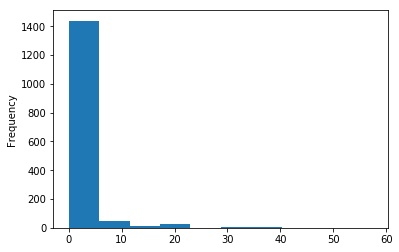

In [13]:
df_test.pc_inv3_excedidas_prom.plot.hist()

In [13]:
df_montos_maximos.Año.unique()

array([2017, 2016, 2015, 2014, 2013, 2012])

## Porcentaje # de procedimientos adjudicados directamente en 2012-2013 vs 2016

In [51]:
from sklearn.linear_model import Ridge, LinearRegression

In [4]:

    
    
print(df_procs_adquisiciones.shape[0],
      df_procs_adquisiciones.CLAVEUC.nunique(),
      df_procs_adquisiciones.NUMERO_PROCEDIMIENTO.nunique())
df_test = tendencia_adjudicacion_directa(df_procs_servicios)
print(df_test.shape)
df_test.head()

459383 1529 309975
(1640, 2)


,CLAVEUC,tendencia_adj_directa
0,002000997,0.000000
1,002000999,-4.426179
2,003000997,0.000000
3,004000995,-26.136364
4,004000998,-2.008305


In [60]:
df_procs_servicios.CLAVEUC.nunique()

1640

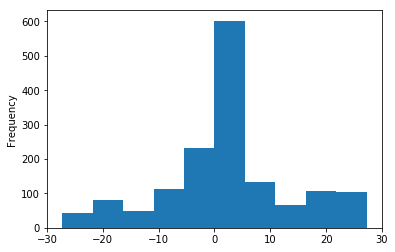

In [55]:
df_test.tendencia_adj_directa.plot.hist()

In [3]:
# df_test.sort_values('tendencia_adj_directa', ascending=False)

In [46]:
df_procs_adquisiciones.loc[df_procs_adquisiciones.CLAVEUC == '019GYN032'].TIPO_PROCEDIMIENTO.value_counts()

ADJUDICACION DIRECTA              780
LICITACION PUBLICA                 71
INVITACION A CUANDO MENOS TRES     28
Name: TIPO_PROCEDIMIENTO, dtype: int64

In [21]:
df_procs_adquisiciones[df_procs_adquisiciones.TIPO_PROCEDIMIENTO == 'ADJUDICACION DIRECTA'].NUMERO_PROCEDIMIENTO.nunique()

264682

In [2]:
# df_test.sample(n=15)

In [17]:
df_procs_adquisiciones.loc[df_procs_adquisiciones.NUMERO_PROCEDIMIENTO == 'SA-008JAG014-N154-2014']

,DEPENDENCIA,SIGLAS,NOMBRE_DE_LA_UC,CLAVEUC,RESPONSABLE,ESTRATIFICACION_MUC,FOLIO_RUPC,PROVEEDOR_CONTRATISTA,ESTATUS_EMPRESA,ESTRATIFICACION_MPC,IMPORTE_CONTRATO,APORTACION_FEDERAL,MONEDA,NUMERO_PROCEDIMIENTO,FORMA_PROCEDIMIENTO,TIPO_PROCEDIMIENTO,CODIGO_CONTRATO,TITULO_CONTRATO,IDENTIFICADOR_CM,TIPO_CONTRATACION,ESTATUS_CONTRATO,COMPRA_CONSOLIDADA,PLURIANUAL,CARACTER,CONTRATO_MARCO,CONVENIO_MODIFICATORIO,PROC_F_PUBLICACION,FECHA_APERTURA_PROPOSICIONES,EXP_F_FALLO,FECHA_CELEBRACION,FECHA_INICIO,FECHA_FIN,CODIGO_EXPEDIENTE,TITULO_EXPEDIENTE,PLANTILLA_EXPEDIENTE,CLAVE_PROGRAMA,CUENTA_ADMINISTRADA_POR,ANUNCIO,ARCHIVADO,SIGLAS_PAIS,RAMO,ORGANISMO,C_EXTERNO,FECHA_ARCHIVO,IMPORTE_PESOS
349676,INSTITUTO NACIONAL DE INVESTIGACIONES FORESTAL...,INIFAP,INIFAP-DEPARTAMENTO DE ADMINISTRACION DEL CENT...,008JAG014,EDMUNDO ACOSTA HERNANDEZ,MEDIANA,nan,MA DEL ROSARIO LOPEZ HERNANDEZ,HABILITADO,None,29911.96,NaN,MXN,SA-008JAG014-N154-2014,MIXTA,ADJUDICACION DIRECTA,655015,ADQ DE PLACA DE VOZ INCLUYE INSTALACION,None,ADQUISICIONES,EXPIRADO,0.0,0.0,NACIONAL,0.0,NO,NaT,NaT,NaT,NaT,2014-11-18,2014-11-24,727891,ADQ DE PLACA DE VOZ INCLUYE INSTALACION,Z15122015 12 ADJUDICACION DIRECTA NACIONAL SIM...,None,UC,https://compranet.funcionpublica.gob.mx/esop/g...,No,MX,NaN,None,NaN,2014,29911.96


In [7]:
df_procs_adquisiciones.TIPO_PROCEDIMIENTO.value_counts(dropna=False)

ADJUDICACION DIRECTA              346448
LICITACION PUBLICA                 71030
INVITACION A CUANDO MENOS TRES     40895
OTRO                                 599
LICITACION PUBLICA CON OSD           371
PROYECTO DE CONVOCATORIA              33
NaN                                    7
Name: TIPO_PROCEDIMIENTO, dtype: int64

## Porcentaje de contratos publicados en 2012-2013 vs publicados en 2016 (transparencia)

## con scraper

In [ ]:
# df = (df.groupby(['CLAVEUC', 'Year'])
#         .NUMERO_PROCEDIMIENTO.nunique()
#         .reset_index()
#         .pivot(index='CLAVEUC', columns='Year', values='NUMERO_PROCEDIMIENTO')
#         .fillna(0))

In [6]:
df_test = tendencia_publicacion_contratos(df_scraper_servicios)
print(df_test.shape)
df_test.head()


(1605, 2)


,CLAVEUC,tendencia_no_publicacion_contratos
0,041A00001,18.464379
1,018TOQ999,7.599528
2,006HHE001,0.582751
3,014000999,-0.670627
4,018TOQ100,8.983957


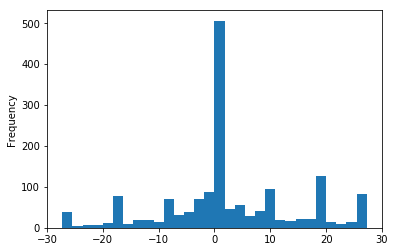

In [7]:
df_test.tendencia_no_publicacion_contratos.plot.hist(bins=30)

In [43]:
df_test.tendencia_no_publicacion_contratos.describe()

count    1502.000000
mean       -0.737473
std        13.628867
min       -30.000000
25%        -9.366114
50%        -0.000000
75%         5.000000
max        30.000000
Name: tendencia_no_publicacion_contratos, dtype: float64

In [1]:
# df_test.sample(frac=0.1)

In [63]:
df_procedimientos.loc[
    (df_procedimientos.CLAVEUC == '019GYN904') &
    (df_procedimientos.FECHA_INICIO.dt.year == 2015)
]

,DEPENDENCIA,SIGLAS,NOMBRE_DE_LA_UC,CLAVEUC,RESPONSABLE,ESTRATIFICACION_MUC,FOLIO_RUPC,PROVEEDOR_CONTRATISTA,ESTATUS_EMPRESA,ESTRATIFICACION_MPC,IMPORTE_CONTRATO,APORTACION_FEDERAL,MONEDA,NUMERO_PROCEDIMIENTO,FORMA_PROCEDIMIENTO,TIPO_PROCEDIMIENTO,CODIGO_CONTRATO,TITULO_CONTRATO,IDENTIFICADOR_CM,TIPO_CONTRATACION,ESTATUS_CONTRATO,COMPRA_CONSOLIDADA,PLURIANUAL,CARACTER,CONTRATO_MARCO,CONVENIO_MODIFICATORIO,PROC_F_PUBLICACION,FECHA_APERTURA_PROPOSICIONES,EXP_F_FALLO,FECHA_CELEBRACION,FECHA_INICIO,FECHA_FIN,CODIGO_EXPEDIENTE,TITULO_EXPEDIENTE,PLANTILLA_EXPEDIENTE,CLAVE_PROGRAMA,CUENTA_ADMINISTRADA_POR,ANUNCIO,ARCHIVADO,SIGLAS_PAIS,RAMO,ORGANISMO,C_EXTERNO,FECHA_ARCHIVO,IMPORTE_PESOS
492105,INSTITUTO DE SEGURIDAD Y SERVICIOS SOCIALES DE...,ISSSTE,ISSSTE-ISSSTE SUPERISSSTE GERENCIA REGIONAL SU...,019GYN904,JOSE CASTANEDA MURILLO,NO MIPYME,12773,DISTRIBUIDORA MAYORISTA DE OFICINAS,HABILITADO,PEQUENA,60344.83,NaN,MXN,SA-019GYN904-N19-2015,PRESENCIAL,ADJUDICACION DIRECTA,780375,ADQUISICION DE MATERIALES Y UTILES DE OFICINA,None,ADQUISICIONES,EXPIRADO,0.0,0.0,NACIONAL,0.0,NO,NaT,NaT,NaT,2015-04-20,2015-04-19,2015-12-31,852863,ADQUISICION DE MATERIALES Y UTILES DE OFICINA,Z15122015 12 ADJUDICACION DIRECTA NACIONAL SIM...,None,PoC,https://compranet.funcionpublica.gob.mx/esop/g...,No,MX,NaN,None,NaN,2015,60344.83
492106,INSTITUTO DE SEGURIDAD Y SERVICIOS SOCIALES DE...,ISSSTE,ISSSTE-ISSSTE SUPERISSSTE GERENCIA REGIONAL SU...,019GYN904,JOSE CASTANEDA MURILLO,MEDIANA,4253,SERVICIOS INDUSTRIALES E INSTITUCIONALES,HABILITADO,NO MIPYME,3877500.00,NaN,MXN,LA-019GYN904-N2-2015,ELECTRONICA,LICITACION PUBLICA,760317,SERVICIO DE SEGURIDAD Y VIGILANCIA,None,SERVICIOS,EXPIRADO,0.0,0.0,NACIONAL,0.0,NO,2015-01-27 02:00:00,2015-02-11 10:00:00,2015-02-20,2015-03-06,2015-03-01,2015-12-31,750033,SERVICIO DE SEGURIDAD Y VIGILANCIA,Z15122015 01 LICITACION PUBLICA NACIONAL LAASSP,None,PoC,https://compranet.funcionpublica.gob.mx/esop/g...,No,MX,NaN,None,NaN,2015,3877500.00
492107,INSTITUTO DE SEGURIDAD Y SERVICIOS SOCIALES DE...,ISSSTE,ISSSTE-ISSSTE SUPERISSSTE GERENCIA REGIONAL SU...,019GYN904,JOSE CASTANEDA MURILLO,NO MIPYME,nan,CENTRO AUTOMOTRIZ MOGUEL,HABILITADO,PEQUENA,155172.41,NaN,MXN,SA-019GYN904-N18-2015,PRESENCIAL,ADJUDICACION DIRECTA,776221,SERVICIO DE MANTENIMIENTO PREVENTIVO Y CORRECT...,None,SERVICIOS,EXPIRADO,0.0,0.0,NACIONAL,0.0,NO,NaT,NaT,NaT,2015-03-31,2015-04-01,2015-12-31,848251,SERVICIO DE MANTENIMIENTO PREVENTIVO Y CORRECT...,Z15122015 12 ADJUDICACION DIRECTA NACIONAL SIM...,None,PoC,https://compranet.funcionpublica.gob.mx/esop/g...,No,MX,NaN,None,NaN,2015,155172.41
492108,INSTITUTO DE SEGURIDAD Y SERVICIOS SOCIALES DE...,ISSSTE,ISSSTE-ISSSTE SUPERISSSTE GERENCIA REGIONAL SU...,019GYN904,JOSE CASTANEDA MURILLO,PEQUENA,nan,EXI YUCATAN,HABILITADO,MICRO,5000.00,NaN,MXN,SA-019GYN904-N4-2015,PRESENCIAL,ADJUDICACION DIRECTA,761769,ARRENDAMIENTO DE EQUIPOS DE FOTOCOPIADO,None,ARRENDAMIENTOS,EXPIRADO,0.0,0.0,NACIONAL,0.0,NO,NaT,NaT,NaT,2015-03-02,2015-03-01,2015-03-31,783581,ARRENDAMIENTO DE EQUIPOS DE FOTOCOPIADO,Z15122015 12 ADJUDICACION DIRECTA NACIONAL SIM...,None,PoC,https://compranet.funcionpublica.gob.mx/esop/g...,No,MX,NaN,None,NaN,2015,5000.00
492109,INSTITUTO DE SEGURIDAD Y SERVICIOS SOCIALES DE...,ISSSTE,ISSSTE-ISSSTE SUPERISSSTE GERENCIA REGIONAL SU...,019GYN904,JOSE CASTANEDA MURILLO,MEDIANA,6373,DHL EXPRESS MEXICO,HABILITADO,NO MIPYME,153771.75,NaN,MXN,SA-019GYN904-N15-2015,PRESENCIAL,ADJUDICACION DIRECTA,772759,SERVICIO DE MENSAJERIA Y PAQUETERIA,None,SERVICIOS,EXPIRADO,0.0,0.0,NACIONAL,0.0,NO,NaT,NaT,NaT,2015-02-16,2015-02-16,2015-12-31,832350,SERVICIO DE MENSAJERIA Y PAQUETERIA,Z15122015 12 ADJUDICACION DIRECTA NACIONAL SIM...,None,PoC,https://compranet.funcionpublica.gob.mx/esop/g...,No,MX,NaN,None,NaN,2015,153771.75
492110,INSTITUTO DE SEGURIDAD Y SERVICIOS SOCIALES DE...,ISSSTE,ISSSTE-ISSSTE SUPERISSSTE GERENCIA REGIONAL SU...,019GYN904,JOSE CASTANEDA MURILLO,MEDIANA,5269,ADT PRIVATE SECURITY SERVICES DE MEXICO,HABILITADO,MEDI

In [43]:
df_aux = df_test.pivot_table(index=['CLAVEUC', 'Year'],
                             columns=['archivo_contrato'],
                             values='NUMERO_PROCEDIMIENTO').reset_index()
df_aux.head()

archivo_contrato,CLAVEUC,Year,0,1
0,002000997,2016,8.0,NaN
1,002000997,2017,21.0,NaN
2,002000998,2014,2.0,NaN
3,002000998,2015,3.0,NaN
4,002000998,2016,3.0,NaN


In [44]:
df_aux.columns

Index(['CLAVEUC', 'Year', 0, 1], dtype='object', name='archivo_contrato')

In [33]:
df_test.Year.isnull().value_counts()

False    8271
Name: Year, dtype: int64

In [40]:
df_aux.columns

MultiIndex(levels=[['NUMERO_PROCEDIMIENTO', 'Year', 'CLAVEUC'], [0, 1, '']],
           labels=[[2, 1, 0, 0], [2, 2, 0, 1]],
           names=[None, 'archivo_contrato'])

In [26]:
df_test.archivo_contrato.value_counts()

0    5797
1    2474
Name: archivo_contrato, dtype: int64

In [12]:
df_scraper_servicios.shape, df_scraper_servicios.NUMERO_PROCEDIMIENTO.nunique()

((275608, 15), 275589)

In [10]:
df_scraper_servicios.CODIGO_EXPEDIENTE.value_counts(dropna=False)

703572     2
993235     2
1106685    2
896757     2
688964     2
1041605    2
1106673    2
686545     2
1014336    2
275459     2
1006561    2
1016641    2
1172929    2
1035591    2
245229     2
1166256    2
1224476    2
1082491    2
989644     2
854673     1
528640     1
1017532    1
861744     1
617336     1
1196831    1
998084     1
291311     1
295799     1
1284613    1
650696     1
895028     1
952180     1
995288     1
211405     1
680650     1
1251449    1
1275229    1
894992     1
748198     1
1306116    1
407561     1
1203780    1
1229709    1
1192305    1
575266     1
802698     1
483257     1
634635     1
1150894    1
1271566    1
          ..
814037     1
1175695    1
813027     1
359982     1
766665     1
1005598    1
759985     1
1036313    1
389927     1
565737     1
941680     1
873878     1
1309015    1
353212     1
543755     1
929784     1
858086     1
354551     1
347363     1
779032     1
425407     1
391070     1
136742     1
901302     1
1082228    1
778652     1

In [16]:
df_scraper.loc[df_scraper.CODIGO_EXPEDIENTE == '1035591']

,CODIGO_EXPEDIENTE,archivo_anexos,archivo_apertura,archivo_contrato,archivo_convocatoria,archivo_fallo,archivo_junta,numero_archivos,numero_convenios,CLAVEUC,NUMERO_PROCEDIMIENTO,TIPO_PROCEDIMIENTO,TIPO_CONTRATACION,numero_contratos,FECHA_INICIO
433661,1035591,0,1,1,1,1,1,8,0,011H00001,LA-011H00001-E12-2016,LICITACION PUBLICA,SERVICIOS,1,2016-05-01
433662,1035591,0,1,1,1,1,1,8,0,048410001,LA-011H00001-E12-2016,LICITACION PUBLICA,SERVICIOS,1,2016-05-01


In [18]:
df_procedimientos.loc[df_procedimientos.NUMERO_PROCEDIMIENTO == 'LA-011D00001-T64-2014'].NOMBRE_DE_LA_UC.values

array(['INAH-DIRECCION DE RECURSOS MATERIALES Y SERVICIOS #011D00001',
       'INAH-DIRECCION DE RECURSOS MATERIALES Y SERVICIOS #048D00001'], dtype=object)

In [9]:
def diferencia_pc_publicacion_contratos(df):
    df = df.copy()
    cols = [
        'CLAVEUC', 'NUMERO_PROCEDIMIENTO',
        'FECHA_INICIO'
    ]
    print(df.shape)
    df = df.loc[:, cols].drop_duplicates()
    print(df.shape)
    df = df.assign(Year=df.FECHA_INICIO.dt.year)
    df = (df.groupby(['CLAVEUC', 'Year'])
            .NUMERO_PROCEDIMIENTO.nunique()
            .reset_index()
            .pivot(index='CLAVEUC', columns='Year', values='NUMERO_PROCEDIMIENTO')
            .fillna(0))
    return df

df_test = diferencia_pc_publicacion_contratos(df_procs_servicios)
print(df_test.shape)
df_test.sample(frac=0.1).head()

(339353, 45)
(306247, 3)
(1640, 6)


Year,2012,2013,2014,2015,2016,2017
CLAVEUC,,,,,,
008000983,4.0,7.0,13.0,14.0,73.0,133.0
019GYN089,1.0,1.0,1.0,0.0,0.0,6.0
03891U001,89.0,74.0,53.0,73.0,69.0,103.0
011L6W998,0.0,0.0,3.0,29.0,24.0,18.0
006HHE001,215.0,78.0,79.0,133.0,112.0,53.0


In [10]:
df_procedimientos.loc[df_procedimientos.CLAVEUC == '006HHE001']

,DEPENDENCIA,SIGLAS,NOMBRE_DE_LA_UC,CLAVEUC,RESPONSABLE,ESTRATIFICACION_MUC,FOLIO_RUPC,PROVEEDOR_CONTRATISTA,ESTATUS_EMPRESA,ESTRATIFICACION_MPC,IMPORTE_CONTRATO,APORTACION_FEDERAL,MONEDA,NUMERO_PROCEDIMIENTO,FORMA_PROCEDIMIENTO,TIPO_PROCEDIMIENTO,CODIGO_CONTRATO,TITULO_CONTRATO,IDENTIFICADOR_CM,TIPO_CONTRATACION,ESTATUS_CONTRATO,COMPRA_CONSOLIDADA,PLURIANUAL,CARACTER,CONTRATO_MARCO,CONVENIO_MODIFICATORIO,PROC_F_PUBLICACION,FECHA_APERTURA_PROPOSICIONES,EXP_F_FALLO,FECHA_CELEBRACION,FECHA_INICIO,FECHA_FIN,CODIGO_EXPEDIENTE,TITULO_EXPEDIENTE,PLANTILLA_EXPEDIENTE,CLAVE_PROGRAMA,CUENTA_ADMINISTRADA_POR,ANUNCIO,ARCHIVADO,SIGLAS_PAIS,RAMO,ORGANISMO,C_EXTERNO,FECHA_ARCHIVO,IMPORTE_PESOS
46877,INSTITUTO FEDERAL DE ACCESO A LA INFORMACION Y...,IFAI,IFAI-DIRECCION GENERAL DE ADMINISTRACION #006H...,006HHE001,ANICETO ALVARADO GONZALEZ,MEDIANA,nan,COMENTARISTAS EN MEDIOS DE COMUNICACION,HABILITADO,MEDIANA,450000.00,NaN,MXN,SA-006HHE001-N66-2012,PRESENCIAL,ADJUDICACION DIRECTA,110207,CONTRATACION DE LOS SERVICIOS DE PUBLICIDAD EN...,None,SERVICIOS,EXPIRADO,0.0,0.0,NACIONAL,0.0,NO,2012-02-27 12:38:00,2012-02-27 17:00:00,NaT,2012-01-13,2012-02-15,2012-12-31,148409,ADJUDICACION DIRECTA SEMANA NACIONAL COMENTARI...,Z15122015 12 ADJUDICACION DIRECTA NACIONAL SIM...,None,PoC,https://compranet.funcionpublica.gob.mx/esop/g...,No,MX,NaN,None,NaN,2012,450000.00
46878,INSTITUTO FEDERAL DE ACCESO A LA INFORMACION Y...,IFAI,IFAI-DIRECCION GENERAL DE ADMINISTRACION #006H...,006HHE001,ANICETO ALVARADO GONZALEZ,MEDIANA,48269,EDICIONES DEL NORTE,HABILITADO,NO MIPYME,57380.40,NaN,MXN,AA-006HHE001-N38-2012,PRESENCIAL,ADJUDICACION DIRECTA,88982,1/4 DE PLANA,None,SERVICIOS,EXPIRADO,0.0,0.0,NACIONAL,0.0,NO,2012-01-31 17:53:00,2012-02-01 17:00:00,NaT,2012-01-26,2012-01-28,2012-01-28,135540,ADJUDICACION DIRECTA INSERCION EDICIONES DEL N...,Z15122015 07 ADJUDICACION DIRECTA NACIONAL ART...,None,PoC,https://compranet.funcionpublica.gob.mx/esop/g...,No,MX,NaN,None,NaN,2012,57380.40
46879,INSTITUTO FEDERAL DE ACCESO A LA INFORMACION Y...,IFAI,IFAI-DIRECCION GENERAL DE ADMINISTRACION #006H...,006HHE001,ANICETO ALVARADO GONZALEZ,NO MIPYME,nan,ROGELIO HERNANDEZ RANGEL,HABILITADO,None,75000.00,NaN,MXN,AA-006HHE001-N165-2012,PRESENCIAL,ADJUDICACION DIRECTA,808926,ADJUDICACION DIRECTA INSERCION,None,SERVICIOS,EXPIRADO,0.0,0.0,NACIONAL,0.0,NO,2012-07-04 16:19:00,2012-07-05 08:00:00,NaT,2012-06-13,2012-04-30,2012-06-30,212075,ADJUDICACION DIRECTA INSERCION HERNANDEZ RANGE...,Z15122015 07 ADJUDICACION DIRECTA NACIONAL ART...,None,UC,https://compranet.funcionpublica.gob.mx/esop/g...,No,MX,NaN,None,NaN,2012,75000.00
46880,INSTITUTO FEDERAL DE ACCESO A LA INFORMACION Y...,IFAI,IFAI-DIRECCION GENERAL DE ADMINISTRACION #006H...,006HHE001,ANICETO ALVARADO GONZALEZ,NO MIPYME,nan,EDITORIAL ANIMAL,HABILITADO,NO MIPYME,10000.00,NaN,MXN,SA-006HHE001-N194-2012,PRESENCIAL,ADJUDICACION DIRECTA,178397,ADJUDICACION DIRECTA TRANSMISION EDITORIAL ANIMAL,None,SERVICIOS,EXPIRADO,0.0,0.0,NACIONAL,0.0,NO,NaT,NaT,NaT,2012-07-06,2012-07-31,2012-08-30,251988,ADJUDICACION DIRECTA TRANSMISION EDITORIAL ANIMAL,Z15122015 12 ADJUDICACION DIRECTA NACIONAL SIM...,None,PoC,https://compranet.funcionpublica.gob.mx/esop/g...,No,MX,NaN,None,NaN,2012,10000.00
46881,INSTITUTO FEDERAL DE ACCESO A LA INFORMACION Y...,IFAI,IFAI-DIRECCION GENERAL DE ADMINISTRACION #006H...,006HHE001,ANICETO ALVARADO GONZALEZ,PEQUENA,nan,EDITORIAL OTRAS INQUISICIONES,HABILITADO,MEDIANA,40560.00,NaN,MXN,AA-006HHE001-N149-2012,PRESENCIAL,ADJUDICACION DIRECTA,142197,INTERIOR PAGINA IMPAR,None,SERVICIOS,EXPIRADO,0.0,0.0,NACIONAL,0.0,NO,2012-07-04 13:37:00,2012-07-04 16:00:00,NaT,NaT,2012-06-09,2012-06-09,211884,ADJUDICACION DIRECTA INSERCION EDITORIAL OTRAS...,Z15122015 07 ADJUDICACION DIRECTA NACIONAL ART...,None,PoC,https://compranet.funcionpublica.gob.mx/esop/g...,No,MX,NaN,None,NaN,2012,40560.00
46882,INSTITUTO FEDERAL DE ACCESO A LA INFORMACION Y...,IFAI,IFAI-DIRECCION GENERAL DE ADMINISTRACION #006H...,006HHE001,ANICETO ALVARADO GONZ

### % de las licitaciones internacionales bajo la cobertura de tratados cuyo plazo fue menor a 40 días

In [9]:
df_test = pc_licitaciones_internacionales_menor_40_dias(df_procs_adquisiciones)
print(df_test.shape)
df_test.head()

(1529, 2)


,CLAVEUC,pc_licitaciones_menor_40
0,009JZL032,0.000000
1,019GYR027,88.235294
2,018TOQ896,0.000000
3,018TQA999,0.000000
4,012K00999,100.000000


In [12]:
# df_procs_adquisiciones.loc[(df_procs_adquisiciones.CLAVEUC == '019GYR027') & 
#                            (df_procs_adquisiciones.CARACTER == 'INTERNACIONAL BAJO TLC')]

## % de las licitaciones internacionales cuyo plazo fue menor a 20 días

In [2]:


df_test = pc_licitaciones_internacionales_menor_20_dias(df_procs_adquisiciones)
print(df_test.shape)
df_test.head()

NameError: name 'pc_licitaciones_internacionales_menor_20_dias' is not defined

In [8]:
# df_procs_adquisiciones.loc[
#     (df_procs_adquisiciones.CLAVEUC == '018TOQ896') &
#     (df_procs_adquisiciones.CARACTER == 'INTERNACIONAL')
# ]

In [4]:
df_procedimientos.CARACTER.value_counts(dropna=False)

NACIONAL                  753325
INTERNACIONAL              85491
INTERNACIONAL BAJO TLC     30785
INTERNACIONAL ABIERTA      10161
SIN REPORTAR                5198
Name: CARACTER, dtype: int64

## % de las licitaciones nacionales cuyo plazo fue menor a 15 días

In [8]:
df_test = pc_licitaciones_nacionales_menor_15_dias(df_procs_servicios)
print(df_test.shape)
df_test.head()

(1640, 2)


,CLAVEUC,pc_licitaciones_menor_15
0,009JZL032,100.000000
1,009JZL021,40.000000
2,019GYR027,23.809524
3,018TOQ896,84.000000
4,018TQA999,66.666667


In [66]:
df_procs_adquisiciones.CLAVEUC.nunique()

1529

In [4]:
# df_test.sort_values('pc_licitaciones_menor_15', ascending=False)

In [36]:
df_test.shape, df_test.NUMERO_PROCEDIMIENTO.nunique()

((53872, 7), 39961)

## Estratificacion no coincide

In [7]:
df_test = diferente_estratificacion(df_procs_servicios)
print(df_test.shape)
df_test.head()

(1640, 2)


,CLAVEUC,pc_estratificacion_mal_reportada
0,002000997,77.777778
1,002000999,47.104247
2,003000997,100.000000
3,004000995,37.254902
4,004000998,48.258706


In [8]:
df_aux = df_procs_adquisiciones

cols_interes = [
    
]

print(df_aux.shape)
df_test = df_aux.drop_duplicates(subset=cols_interes)
# 
print(df_test.shape)

df_test = df_test.loc[:, cols_interes + ['ESTRATIFICACION_MUC', 'ESTRATIFICACION_MPC', 'IMPORTE_PESOS']]
df_test = df_test.sort_values('NUMERO_PROCEDIMIENTO')
df_test.head()

(459383, 45)
(459383, 45)


,CLAVEUC,PROVEEDOR_CONTRATISTA,NUMERO_PROCEDIMIENTO,CODIGO_EXPEDIENTE,CODIGO_CONTRATO,ESTRATIFICACION_MUC,ESTRATIFICACION_MPC,IMPORTE_PESOS
777678,002000997,PRODUCTOS DENTALES TOVAR SA,AA-002000997-E10-2016,1192354,1232372,NO MIPYME,MICRO,43086.21
777681,002000997,ROMUALDO BAUTISTA CRUZ,AA-002000997-E11-2016,1192355,1232373,NO MIPYME,MICRO,5869.60
777676,002000997,RUMA GROUP INCORPORATED,AA-002000997-E12-2016,1192357,1232377,NO MIPYME,PEQUENA,450211.00
777680,002000997,UNIVERSAL EXTINTORES,AA-002000997-E9-2016,1192352,1232370,NO MIPYME,MICRO,7085.00
677865,002000999,PROCESADORA Y DISTRIBUIDORA LOS CHANEQUES,AA-002000999-E110-2015,975510,964553,MEDIANA,MEDIANA,7000000.00


In [9]:
df_test.ESTRATIFICACION_MPC.value_counts(dropna=False)

PEQUENA      116607
NaN          111327
MICRO        102380
MEDIANA       74409
NO MIPYME     54660
Name: ESTRATIFICACION_MPC, dtype: int64

In [10]:
df_test.ESTRATIFICACION_MUC.value_counts(dropna=False)

PEQUENA      143412
NO MIPYME    129020
MICRO        112246
MEDIANA       74702
NaN               3
Name: ESTRATIFICACION_MUC, dtype: int64

In [8]:
df_test.NUMERO_PROCEDIMIENTO.nunique()

309975

## Calculo de Features

In [5]:
funciones_procedimientos = {
    'general': [
        monto_por_unidad_compradora,
        proveedores_distintos,
        procedimientos_distintos,
        numero_de_contratos,
    ],
    'competencia': [
        contratos_por_proveedor,
        porcentaje_procedimientos_por_tipo,
        porcentaje_monto_tipo_procedimiento,
        importe_promedio_por_contrato,
        calcular_IHH_ID_contratos,
        calcular_IHH_ID_monto,
        
    ],
    'transparencia': [
        porcentaje_procedimientos_presenciales,
        contratos_promedio_por_procedimimento,
        contratos_por_duracion,
        monto_por_duracion,
        promedio_datos_faltantes_poc_contrato,
    ],
    'anomalias': [
        interaccion_rfc_fantasma,
        interaccion_sancionados,
        porcentaje_contratos_por_convenio,
    ]
}


funciones_scraper = {
    'general': [
        
    ],
    'competencia': [
            
    ],
    'transparencia': [
        porcentaje_procs_sin_contrato,
        porcentaje_procs_sin_fallo,
        porcentaje_procs_sin_apertura,
        porcentaje_procedimientos_sin_archivos,
        promedio_procs_por_archivo,
    ],
    'anomalias': [
        promedio_convenios_por_proc,
        porcentaje_procs_sin_junta_aclaracion,
        porcentaje_procs_sin_convocatoria,
        porcentaje_adjudicaciones_incompletas,
        porcentaje_invitaciones_incompletas,
        porcentaje_licitaciones_incompletas,
    ]
    
}

conceptos = tuple(funciones_procedimientos.keys())

tipos_contratacion = (
    'ADQUISICIONES',
    'SERVICIOS',
    'OBRA PUBLICA',
    'ARRENDAMIENTOS',
    'SERVICIOS RELACIONADOS CON LA OP'
)

for concepto in conceptos:
    for tipo in tipos_contratacion:
        # sub-tablas
        df_procs_aux = df_procedimientos.loc[
            (df_procedimientos.TIPO_CONTRATACION == tipo)
        ]
        df_scraper_aux = df_scraper.loc[
            (df_scraper.TIPO_CONTRATACION == tipo)
        ]
        # se agarran las funciones para cada tabla
        functions_procs_in_concept = funciones_procedimientos[concepto]
        functions_scraper_in_concept = funciones_scraper[concepto]
        print(concepto, tipo)
        # Calculo de features
        df_features_procs = [
            function(df_procs_aux).set_index('CLAVEUC')
            for function in functions_procs_in_concept
        ]
        # print([df.shape for df in df_features_procs])
        df_features_scraper = [
            function(df_scraper_aux).set_index('CLAVEUC')
            for function in functions_scraper_in_concept
        ]
        # print([df.shape for df in df_features_scraper])
        # join de features por tabla en concepto
        # Se asume que procedimientos es la BASE PRINCIPAL
        # Join de tablas en el concetp
        df_features = pd.concat(df_features_procs, join='inner', axis=1)
        df_features = df_features.reset_index()
        if len(df_features_scraper) > 0:
            df_features_scraper = pd.concat(df_features_scraper, join='inner', axis=1)
            df_features_scraper = df_features_scraper.reset_index()
            df_features = pd.merge(df_features, df_features_scraper, on='CLAVEUC', how='left')
        file_path = os.path.join('../data/conceptos/', concepto, tipo, 'features.csv')
        df_features.to_csv(file_path, index=False, quoting=1, encoding='utf-8')
        print(file_path)
        print('-' * 50)


general ADQUISICIONES
../data/conceptos/general/ADQUISICIONES/features.csv
--------------------------------------------------
general SERVICIOS
../data/conceptos/general/SERVICIOS/features.csv
--------------------------------------------------
general OBRA PUBLICA
../data/conceptos/general/OBRA PUBLICA/features.csv
--------------------------------------------------
general ARRENDAMIENTOS
../data/conceptos/general/ARRENDAMIENTOS/features.csv
--------------------------------------------------
general SERVICIOS RELACIONADOS CON LA OP
../data/conceptos/general/SERVICIOS RELACIONADOS CON LA OP/features.csv
--------------------------------------------------
competencia ADQUISICIONES
../data/conceptos/competencia/ADQUISICIONES/features.csv
--------------------------------------------------
competencia SERVICIOS
../data/conceptos/competencia/SERVICIOS/features.csv
--------------------------------------------------
competencia OBRA PUBLICA
../data/conceptos/competencia/OBRA PUBLICA/features.csv

In [ ]:
#         # TODO: Por qué aquí no es outter?
#         df_features = pd.concat(df_features, join='inner', axis=1)
#         df_features = df_features.reset_index()
#         # df_features = df_features.assign(nombre_uc=df_features.CLAVEUC.map(nombres_uc))
#         # df_features = df_features.assign(dependencia=df_features.CLAVEUC.map(nombres_dep))
#         file_path = os.path.join('../data/conceptos/', concepto, tipo, 'features.csv')
#         df_features.to_csv(file_path, index=False, quoting=1, encoding='utf-8')
#         print(file_path)
#         print('-' * 50)

In [6]:
df_test_procs = pd.concat(df_features_procs, join='inner', axis=1)
df_test_scraper = pd.concat(df_features_scraper, join='inner', axis=1)

## Features scraper 

In [4]:
df_scraper_adquisiciones = df_scraper.loc[df_scraper.TIPO_CONTRATACION == 'ADQUISICIONES']
df_scraper_servicios = df_scraper.loc[df_scraper.TIPO_CONTRATACION == 'SERVICIOS']
# 'OBRA PUBLICA', 'ARRENDAMIENTOS', 'SERVICIOS RELACIONADOS CON LA OP'
print(df_scraper_adquisiciones.shape[0], df_scraper_servicios.shape[0])

278722 275608


In [58]:
def porcentaje_adjudicaciones_incompletas(df):
    """Usa tabla scraper.
    Calcula el porcentaje de procedimientos (adjudicaciones directas) 
    con documentacion incompleta"""
    df_claves = pd.DataFrame(
        data=df.CLAVEUC.unique(), columns=['CLAVEUC'])
    tipos_validos = {'ADJUDICACION DIRECTA',}
    df = df.loc[df.TIPO_PROCEDIMIENTO.isin(tipos_validos)].copy()
    df = df.reset_index(drop=True)
    # Archvios
    archivos = [
        'archivo_contrato',
    ]
    df = df.assign(
        suma_archivos=lambda dataframe: dataframe[archivos].sum(axis=1)
    )
    df_feature = df.groupby(
        ['CLAVEUC', 'suma_archivos'], as_index=False
    ).CODIGO_EXPEDIENTE.count()
    df_feature = (df_feature.pivot(index='CLAVEUC',
                                   columns='suma_archivos',
                                   values='CODIGO_EXPEDIENTE')
                            .fillna(0))
    
    if len(archivos) not in df_feature.columns:
        raise ValueError('Nadie tuvo los archivos completos')
    df_feature = (df_feature * 100).divide(df_feature.sum(axis=1), axis=0)
    df_feature = df_feature.assign(
        pc_adjudicaciones_incompletas=df_feature.drop({len(archivos)}, axis=1).sum(axis=1)
    )
    df_feature = (df_feature.reset_index()
                            .loc[:, ['CLAVEUC', 'pc_adjudicaciones_incompletas']])
    df_feature  = pd.merge(df_claves, df_feature, on='CLAVEUC', how='left')
    df_feature = df_feature.fillna(0)
    return df_feature

df_test = porcentaje_adjudicaciones_incompletas(df_scraper_servicios)
print(df_test.shape)
df_test.head()

(1605, 2)


,CLAVEUC,pc_adjudicaciones_incompletas
0,041A00001,45.502646
1,018TOQ999,18.210863
2,006HHE001,98.797595
3,014000999,98.128342
4,018TOQ100,99.492386


In [62]:
from inspect import getmembers, isfunction
from src import _features_scraper
functions_list = [o for o in getmembers(_features_scraper, isfunction)]
functions_list

[('porcentaje_adjudicaciones_incompletas',
  <function src._features_scraper.porcentaje_adjudicaciones_incompletas>),
 ('porcentaje_invitaciones_incompletas',
  <function src._features_scraper.porcentaje_invitaciones_incompletas>),
 ('porcentaje_licitaciones_incompletas',
  <function src._features_scraper.porcentaje_licitaciones_incompletas>),
 ('porcentaje_procedimientos_sin_archivos',
  <function src._features_scraper.porcentaje_procedimientos_sin_archivos>),
 ('porcentaje_procs_sin_apertura',
  <function src._features_scraper.porcentaje_procs_sin_apertura>),
 ('porcentaje_procs_sin_contrato',
  <function src._features_scraper.porcentaje_procs_sin_contrato>),
 ('porcentaje_procs_sin_convocatoria',
  <function src._features_scraper.porcentaje_procs_sin_convocatoria>),
 ('porcentaje_procs_sin_fallo',
  <function src._features_scraper.porcentaje_procs_sin_fallo>),
 ('porcentaje_procs_sin_junta_aclaracion',
  <function src._features_scraper.porcentaje_procs_sin_junta_aclaracion>),
 ('pro

In [5]:
# df_test = promedio_convenios_por_proc(df_scraper_adquisiciones)
# df_test = df_test.sort_values(df_test.columns[1], ascending=False)
# print(df_test.shape)
# df_test.head()

In [6]:
# 'OBRA PUBLICA', 'ARRENDAMIENTOS', 'SERVICIOS RELACIONADOS CON LA OP', 'ADQUISICIONES'
# df_aux = df_scraper.loc[df_scraper.TIPO_CONTRATACION == 'SERVICIOS RELACIONADOS CON LA OP'].copy()
# df_test = df_aux.groupby(
#     ['CLAVEUC', 'numero_archivos'], as_index=False).CODIGO_EXPEDIENTE.count()
# df_test = df_test.pivot(index='CLAVEUC', columns='numero_archivos', values='CODIGO_EXPEDIENTE')
# df_test = df_test.fillna(0)

# df_test.head()

## Calcular features (Falta agregar a datos generales el scraper para poder filtrar)

In [4]:
funciones_procedimientos = {
    'general': [
        monto_por_unidad_compradora,
        proveedores_distintos,
        procedimientos_distintos,
        numero_de_contratos,
    ],
    'competencia': [
        contratos_por_proveedor,
        porcentaje_procedimientos_por_tipo,
        porcentaje_monto_tipo_procedimiento,
        importe_promedio_por_contrato,
        calcular_IHH_ID_contratos,
        calcular_IHH_ID_monto,
        
    ],
    'transparencia': [
        porcentaje_procedimientos_presenciales,
        contratos_promedio_por_procedimimento,
        contratos_por_duracion,
        monto_por_duracion,
        promedio_datos_faltantes_poc_contrato,
    ],
    'anomalias': [
        interaccion_rfc_fantasma,
        interaccion_sancionados,
        porcentaje_contratos_por_convenio,
    ]
}


conceptos = tuple(funciones_procedimientos.keys())

tipos_contratacion = (
    'ADQUISICIONES',
    'SERVICIOS',
    'OBRA PUBLICA',
    'ARRENDAMIENTOS',
    'SERVICIOS RELACIONADOS CON LA OP'
)

for concepto in conceptos:
    for tipo in tipos_contratacion:
        # sub-tabla procedimientos
        df_procs_aux = df_procedimientos.loc[
            (df_procedimientos.TIPO_CONTRATACION == tipo)
        ]
        # sub-tabla scraper
        df_procs_aux = df_procedimientos.loc[
            (df_procedimientos.TIPO_CONTRATACION == tipo)
        ]
        functions_in_concept = funciones_procedimientos[concepto]
        df_features_procs = [
            function(df_procs_aux).set_index('CLAVEUC')
            for function in functions_in_concept
        ]
        # TODO: Por qué aquí no es outter?
        df_features = pd.concat(df_features, join='inner', axis=1)
        df_features = df_features.reset_index()
        # df_features = df_features.assign(nombre_uc=df_features.CLAVEUC.map(nombres_uc))
        # df_features = df_features.assign(dependencia=df_features.CLAVEUC.map(nombres_dep))
        file_path = os.path.join('../data/conceptos/', concepto, tipo, 'features.csv')
        df_features.to_csv(file_path, index=False, quoting=1, encoding='utf-8')
        print(file_path)
        print('-' * 50)

../data/conceptos/general/ADQUISICIONES/features.csv
--------------------------------------------------
../data/conceptos/general/SERVICIOS/features.csv
--------------------------------------------------
../data/conceptos/general/OBRA PUBLICA/features.csv
--------------------------------------------------
../data/conceptos/general/ARRENDAMIENTOS/features.csv
--------------------------------------------------
../data/conceptos/general/SERVICIOS RELACIONADOS CON LA OP/features.csv
--------------------------------------------------
../data/conceptos/competencia/ADQUISICIONES/features.csv
--------------------------------------------------
../data/conceptos/competencia/SERVICIOS/features.csv
--------------------------------------------------
../data/conceptos/competencia/OBRA PUBLICA/features.csv
--------------------------------------------------
../data/conceptos/competencia/ARRENDAMIENTOS/features.csv
--------------------------------------------------
../data/conceptos/competencia/SERVICI

In [10]:
df_test = pd.DataFrame(np.arange(0, 12).reshape(4, 3), columns=['uno', 'dos', 'tres'])
df_test = df_test.rename(columns={c: (c + '_algo') for c in df_test.columns})
df_test

,uno_algo,dos_algo,tres_algo
0,0,1,2
1,3,4,5
2,6,7,8
3,9,10,11


## Análisis sancionados

In [5]:
df = pd.merge(
    df_procedimientos, df_sancionados,
    on='PROVEEDOR_CONTRATISTA', how='inner'
)
monto_por_contrato_fant = df.groupby(
    ['FECHA_ARCHIVO', 'DEPENDENCIA', 'CLAVEUC', 'PROVEEDOR_CONTRATISTA',
     'NUMERO_PROCEDIMIENTO', 'CODIGO_CONTRATO'],
    as_index=False
).IMPORTE_PESOS.sum()

contratos = monto_por_contrato_fant.groupby(
    ['FECHA_ARCHIVO', 'DEPENDENCIA'], as_index=False).CODIGO_CONTRATO.count()
contratos = contratos.pivot(index='FECHA_ARCHIVO', columns='DEPENDENCIA', values='CODIGO_CONTRATO')
contratos = contratos.fillna(0)
contratos = contratos.astype(int)
top_dep_contratos = contratos.sum().sort_values(ascending=False).index[0:10]

In [ ]:
with plt.style.context('randy_olson_style'):
    import seaborn as sns
    fig, ax = plt.subplots(ncols=1, nrows=1, figsize=(20, 7))
    df_aux = contratos.loc[:, top_dep_contratos].T
    df_aux.columns.name = 'AÑO'
    sns.heatmap(df_aux, annot=True, cmap='magma', fmt='d')
    plt.tight_layout()

### Análisis de fantasma

In [7]:
# RFC fantasma
df_fantasma = pd.read_csv(
    '../data/processed/rfc_fantasmas.psv', sep='|', usecols=['RFC', 'NOMBRE DEL CONTRIBUYENTE'],
    dtype={'RFC': str, 'NOMBRE DEL CONTRIBUYENTE': str}
)
df_fantasma = df_fantasma.loc[df_fantasma.RFC != 'XXXXXXXXXXXX']
df_fantasma = clean_rfc_fantasma(df_fantasma)
df = pd.merge(
    df_procedimientos, df_fantasma,
    on='PROVEEDOR_CONTRATISTA', how='inner'
)
monto_por_contrato_fant = df.groupby(
    ['FECHA_ARCHIVO', 'DEPENDENCIA', 'CLAVEUC', 'PROVEEDOR_CONTRATISTA',
     'NUMERO_PROCEDIMIENTO', 'CODIGO_CONTRATO'],
    as_index=False
).IMPORTE_PESOS.sum()

contratos = monto_por_contrato_fant.groupby(
    ['FECHA_ARCHIVO', 'DEPENDENCIA'], as_index=False).CODIGO_CONTRATO.count()
contratos = contratos.pivot(index='FECHA_ARCHIVO', columns='DEPENDENCIA', values='CODIGO_CONTRATO')
contratos = contratos.fillna(0)
contratos = contratos.astype(int)
top_dep_contratos = contratos.sum().sort_values(ascending=False).index[0:10]

In [ ]:
with plt.style.context('randy_olson_style'):
    import seaborn as sns
    fig, ax = plt.subplots(ncols=1, nrows=1, figsize=(20, 7))
    df_aux = contratos.loc[:, top_dep_contratos].T
    df_aux.columns.name = 'AÑO'
    sns.heatmap(df_aux, annot=True, cmap='magma')
    plt.tight_layout()

In [1]:
# # RUPC
# df_rupc = pd.read_excel(
#     '../data/raw/RUPC_171011060240.xlsx',
#     dtype={'FOLIO_RUPC': str, 'RFC': str, 'CONTRATOS': int}
# )
# df_rupc = clean_rupc(df_rupc)
# 'JUAN RAMON GARCIA SANCHEZ'
# df_rupc.head()
# df_rupc.PROVEEDOR_CONTRATISTA.nunique(), df_rupc.FOLIO_RUPC.nunique()

# orden
* Fecha publicacion
* fecha apertura
* fecha fallo
* Fecha celebracion
* fecha inicio
* fecha fin

####  fecha apertura - fecha publicacion
#### fecha fallo - fecha_apertura
#### fecha celebracion - fecha fallo
####  fecha_fin - fecha_inico

## clean sancionados

In [4]:
def calcular_duracion(df, breakpoints=None, labels=None):
    """Cuenta el número de contratos que la unidad compradora tuvo
    en los intervalos de tiempo especificados"""
    if breakpoints is None:
        breakpoints = [0, 1, 5, 10, 20]
    if labels is None:
        labels = [
            'dias_sin_rango',
            'mismo_dia', 'uno_cinco_dias', 'cinco_diez_dias',
            'diez_veinte_dias', 'veinte_o_mas_dias'
        ]
    # TODO: verificar sizes de breapoints y labels
    monto_por_contrato = df.groupby(
        ['CLAVEUC', 'PROVEEDOR_CONTRATISTA', 'NUMERO_PROCEDIMIENTO',
         'CODIGO_CONTRATO', 'FECHA_INICIO', 'FECHA_FIN'],
        as_index=False
    ).IMPORTE_PESOS.sum()
    delta_dias = (monto_por_contrato.FECHA_FIN - monto_por_contrato.FECHA_INICIO).dt.days
    monto_por_contrato = monto_por_contrato.assign(delta_dias=delta_dias)

    # adding labels
    monto_por_contrato = monto_por_contrato.assign(
        grupo_dias=monto_por_contrato.delta_dias.map(
            lambda d: labels[bisect.bisect(breakpoints, d)]
        )
    )
    return monto_por_contrato

df_test = calcular_duracion(df_procs_adquisiciones)
df_test.head()

,CLAVEUC,PROVEEDOR_CONTRATISTA,NUMERO_PROCEDIMIENTO,CODIGO_CONTRATO,FECHA_INICIO,FECHA_FIN,IMPORTE_PESOS,delta_dias,grupo_dias
0,002000997,ALBINO CHAVEZ DIAZ,IA-002000997-E19-2017,1369813,2017-01-04,2017-12-31,3189458.00,361,veinte_o_mas_dias
1,002000997,ALL DEPOT,IA-002000997-E29-2017,1404736,2017-04-26,2017-05-11,902454.53,15,diez_veinte_dias
2,002000997,ALL DEPOT,IA-002000997-E32-2017,1462608,2017-06-19,2017-12-31,487296.69,195,veinte_o_mas_dias
3,002000997,CAVANOVA,IA-002000997-E23-2017,1369840,2017-01-05,2017-12-31,769915.00,360,veinte_o_mas_dias
4,002000997,CEDAPSA,IA-002000997-E6-2016,1232347,2016-05-30,2016-06-21,463450.00,22,veinte_o_mas_dias


In [10]:
df_test.grupo_dias.value_counts(dropna=False)

veinte_o_mas_dias    252559
diez_veinte_dias     129254
cinco_diez_dias       49789
uno_cinco_dias        21750
mismo_dia              6091
Name: grupo_dias, dtype: int64

In [ ]:
df_test = contratos_por_duracion(df_procs_adquisiciones)

print(df_test.shape[0], df_test.CLAVEUC.nunique())
df_test.head()

In [3]:
# df_test.sort_values(['NUMERO_PROCEDIMIENTO', 'CODIGO_CONTRATO'])
# df_test.groupby('NUMERO_PROCEDIMIENTO').FECHA_INICIO.nunique().sort_values(ascending=False)

In [4]:
# df_test.loc[df_test.NUMERO_PROCEDIMIENTO == 'AA-012NAW001-N18-2015']

In [3]:
# # Porcentaje de procedimientos que empiezan y acaban el mismo día
# def diferencia_inicio_fin(df):
#     monto_por_contrato = df.groupby(
#         ['CLAVEUC', 'PROVEEDOR_CONTRATISTA', 'NUMERO_PROCEDIMIENTO',
#          'CODIGO_CONTRATO', 'FECHA_INICIO', 'FECHA_FIN'],
#         as_index=False
#     ).IMPORTE_PESOS.sum()
#     delta_dias = (monto_por_contrato.FECHA_FIN - monto_por_contrato.FECHA_INICIO).dt.days
#     monto_por_contrato = monto_por_contrato.assign(delta_dias=delta_dias)
#     # adding labels
#     breakpoints = [0, 1, 5, 10, 20]
#     labels = [
#         'dias_sin_rango', 'mismo_dia', 'uno_cinco_dias',
#         'cinco_diez_dias', 'diez_veinte_dias', 'veinte_o_mas_dias'
#     ]
#     monto_por_contrato = monto_por_contrato.assign(
#         grupo_dias=monto_por_contrato.delta_dias.map(
#             lambda d: labels[bisect.bisect(breakpoints, d)]
#         )
#     )
#     return monto_por_contrato

# df_dias = diferencia_inicio_fin(df_procs_servicios)
# df_dias.head()

## 1 / Diferencia entre el valor promedio del importe del contrato Licitación vs Adj directa

## La UC trata con proveedores sancionados (dummy)

## Tratar con RFC fantasmas (Dummy)

In [9]:
# df_procs_obra_publica.loc[df_procs_obra_publica.CLAVEUC == '003000999']

In [8]:
# df_procs_servicios.loc[df_procs_servicios.CLAVEUC == '040100998']

In [3]:
# df_nombres_uc = df_procedimientos.loc[:, ['CLAVEUC', 'NOMBRE_DE_LA_UC']].drop_duplicates()
# nombres_uc = {row.CLAVEUC: row.NOMBRE_DE_LA_UC for row in df_nombres_uc.itertuples()}

# df_nombres_dep = df_procedimientos.loc[:, ['CLAVEUC', 'DEPENDENCIA']].drop_duplicates()
# nombres_dep = {row.CLAVEUC: row.DEPENDENCIA for row in df_nombres_dep.itertuples()}

# print(df_nombres.shape, df_nombres.CLAVEUC.nunique(), df_nombres.NOMBRE_DE_LA_UC.nunique())
# df_nombres.head()

In [15]:
# df_nombres.groupby('CLAVEUC').NOMBRE_DE_LA_UC.count().sort_values(ascending=False)

In [11]:
df_nombres.loc[df_nombres.CLAVEUC == '015000997']

,CLAVEUC,NOMBRE_DE_LA_UC
287579,015000997,SEDATU-SRA980428JG3
381081,015000997,SEDATU-SRA980428JG3 #015000997


## Calcular indicadores por tipo de contratacion

In [9]:
# df_procedimientos.loc[df_procedimientos.CLAVEUC == '006A00997'].PROVEEDOR_CONTRATISTA.value_counts()

## Calcular indicadores por año y tipo de contratacion

In [3]:
function_list = [
    # competencia
    contratos_por_proveedor,
    porcentaje_procedimientos_por_tipo,
    porcentaje_monto_tipo_procedimiento,
    importe_promedio_por_contrato,
    calcular_IHH,
    # transparencia
    porcentaje_procedimientos_presenciales
]


years = tuple(range(2012, 2018))
tipos_contratacion = (
    'ADQUISICIONES', 'SERVICIOS', 'OBRA PUBLICA', 'ARRENDAMIENTOS',
    'SERVICIOS RELACIONADOS CON LA OP'
)

for year, tipo in product(years, tipos_contratacion):
    
    df_aux = df_procedimientos.loc[
        (df_procedimientos.FECHA_INICIO.dt.year == year) &
        (df_procedimientos.TIPO_CONTRATACION == tipo)
    ]
    df_features = [function(df_aux).set_index('CLAVEUC') for function in function_list]
    df_features = pd.concat(df_features, join='inner', axis=1)
    df_features = df_features.reset_index()
    file_path = os.path.join('../data/features/', str(year), tipo, 'features.csv')
    df_features.to_csv(file_path, index=False, quoting=1, encoding='utf-8')
    print(file_path)

../data/features/2012/ADQUISICIONES/features.csv
../data/features/2012/SERVICIOS/features.csv
../data/features/2012/OBRA PUBLICA/features.csv
../data/features/2013/ADQUISICIONES/features.csv
../data/features/2013/SERVICIOS/features.csv
../data/features/2013/OBRA PUBLICA/features.csv
../data/features/2014/ADQUISICIONES/features.csv
../data/features/2014/SERVICIOS/features.csv
../data/features/2014/OBRA PUBLICA/features.csv
../data/features/2015/ADQUISICIONES/features.csv
../data/features/2015/SERVICIOS/features.csv
../data/features/2015/OBRA PUBLICA/features.csv
../data/features/2016/ADQUISICIONES/features.csv
../data/features/2016/SERVICIOS/features.csv
../data/features/2016/OBRA PUBLICA/features.csv
../data/features/2017/ADQUISICIONES/features.csv
../data/features/2017/SERVICIOS/features.csv
../data/features/2017/OBRA PUBLICA/features.csv


## Leer features

In [4]:
df_procedimientos.TIPO_CONTRATACION.value_counts(dropna=False)

ADQUISICIONES                       391062
SERVICIOS                           297925
OBRA PUBLICA                         54569
SERVICIOS RELACIONADOS CON LA OP     19438
ARRENDAMIENTOS                        4807
Name: TIPO_CONTRATACION, dtype: int64

In [9]:
{col: 'pc_contratos_' + col.replace(' ', '_').lower()  for col in df_procedimientos.TIPO_PROCEDIMIENTO.value_counts().index.values}

{'ADJUDICACION DIRECTA FEDERAL': 'pc_contratos_adjudicacion_directa_federal',
 'INVITACION A CUANDO MENOS 3 PERSONAS': 'pc_contratos_invitacion_a_cuando_menos_3_personas',
 'LICITACION PUBLICA': 'pc_contratos_licitacion_publica',
 'LICITACION PUBLICA CON OSD': 'pc_contratos_licitacion_publica_con_osd',
 'OTRO': 'pc_contratos_otro',
 'PROYECTO DE CONVOCATORIA': 'pc_contratos_proyecto_de_convocatoria'}

In [4]:
df_procs_adquisiciones = df_procedimientos.loc[df_procedimientos.TIPO_CONTRATACION == 'ADQUISICIONES']
df_procs_servicios = df_procedimientos.loc[df_procedimientos.TIPO_CONTRATACION == 'SERVICIOS']
df_procs_obra_publica = df_procedimientos.loc[df_procedimientos.TIPO_CONTRATACION == 'OBRA PUBLICA']


In [3]:
df_procedimientos.TIPO_CONTRATACION.value_counts(dropna=False)

ADQUISICIONES                       391062
SERVICIOS                           297925
OBRA PUBLICA                         54569
SERVICIOS RELACIONADOS CON LA OP     19438
ARRENDAMIENTOS                        4807
Name: TIPO_CONTRATACION, dtype: int64

In [10]:
df_procedimientos.ESTATUS_CONTRATO.value_counts(dropna=False)

EXPIRADO     700642
TERMINADO     41960
ACTIVO        25199
Name: ESTATUS_CONTRATO, dtype: int64

In [8]:
df_procedimientos.FORMA_PROCEDIMIENTO.value_counts(dropna=False)

Mixta                   263835
Presencial              229257
Electrónica             222010
NaN                      52658
Presencial (Estatal)        41
Name: FORMA_PROCEDIMIENTO, dtype: int64

In [9]:
monto_por_contrato = df_procs_adquisiciones.groupby(
    ['DEPENDENCIA', 'CLAVEUC', 'PROVEEDOR_CONTRATISTA', 'NUMERO_PROCEDIMIENTO',
     'CODIGO_CONTRATO', 'FORMA_PROCEDIMIENTO'],
    as_index=False
).IMPORTE_PESOS.sum()
monto_por_contrato.head()

,DEPENDENCIA,CLAVEUC,PROVEEDOR_CONTRATISTA,NUMERO_PROCEDIMIENTO,CODIGO_CONTRATO,FORMA_PROCEDIMIENTO,IMPORTE_PESOS
0,ADMINISTRACION FEDERAL DE SERVICIOS EDUCATIVOS...,011C00999,2MAS DESARROLLO,AA-011C00999-E172-2016,1274658,Mixta,191689.41
1,ADMINISTRACION FEDERAL DE SERVICIOS EDUCATIVOS...,011C00999,2MAS DESARROLLO,AA-011C00999-E173-2016,1274614,Mixta,249135.98
2,ADMINISTRACION FEDERAL DE SERVICIOS EDUCATIVOS...,011C00999,2MAS DESARROLLO,AA-011C00999-E29-2016,1115557,Mixta,310332.04
3,ADMINISTRACION FEDERAL DE SERVICIOS EDUCATIVOS...,011C00999,2MAS DESARROLLO,AA-011C00999-E77-2016,1169944,Mixta,335215.13
4,ADMINISTRACION FEDERAL DE SERVICIOS EDUCATIVOS...,011C00999,2MAS DESARROLLO,AA-011C00999-E90-2016,1191267,Mixta,101735.38


# Features (ADQUISICIONES)

### Porcentaje de procesos presenciales

In [11]:
df_test = porcentaje_procedimientos_presenciales(df_procs_adquisiciones)
df_test.head()

,CLAVEUC,Electrónica,Mixta,Presencial,Presencial (Estatal)
0,002000997,20.000000,0.000000,80.000000,0.0
1,002000998,100.000000,0.000000,0.000000,0.0
2,002000999,1.612903,63.709677,34.677419,0.0
3,003000997,0.000000,4.000000,92.000000,4.0
4,004000995,0.000000,53.846154,46.153846,0.0


### Número de proveedores distintos por contrato

In [4]:
df_test = proveedores_por_contrato(df_procs_adquisiciones)
df_test.head()

,CLAVEUC,proveedores_por_contrato
0,002000997,0.900000
1,002000998,0.602564
2,002000999,0.698413
3,003000997,0.525000
4,004000995,0.857143


### Valor promedio del importe del contrato

In [5]:
df_test = importe_promedio_por_contrato(df_procs_adquisiciones)
df_test.head()

,CLAVEUC,monto_contrato_promedio
0,002000997,172016.703400
1,002000998,361292.915513
2,002000999,843075.567864
3,003000997,496076.516500
4,004000995,802756.780476


### Porcentaje de contrataciones (número y monto) por adjudicación directa e inv3

In [18]:
df_procedimientos.TIPO_PROCEDIMIENTO.value_counts(dropna=False)

ADJUDICACION DIRECTA FEDERAL            563561
LICITACION PUBLICA                      116820
INVITACION A CUANDO MENOS 3 PERSONAS     85263
OTRO                                      1471
LICITACION PUBLICA CON OSD                 388
PROYECTO DE CONVOCATORIA                   297
NaN                                          1
Name: TIPO_PROCEDIMIENTO, dtype: int64

In [36]:
df_test = pd.merge(contratos_total, contratos_distintos, on=['CLAVEUC', 'NUMERO_PROCEDIMIENTO'], how='inner')
print(df_test.shape)

(260096, 4)


In [ ]:
# contratos_distintos = monto_contrato_adquisiciones.groupby(
#     ['CLAVEUC', 'NUMERO_PROCEDIMIENTO']).CODIGO_CONTRATO.nunique()
# contratos_distintos = contratos_distintos.reset_index().sort_values('CODIGO_CONTRATO', ascending=False)
# contratos_distintos = contratos_distintos.rename(columns={'CODIGO_CONTRATO': 'nunique_contratos'})
#

# # with plt.style.context('randy_olson_style'):
# #     df_feature.proveedores_por_contrato.plot.hist(50)
# # df_feature.sort_values('proveedores_por_contrato')
# # df_procedimientos.loc[df_procedimientos.CLAVEUC == '011MAX001']
# print(monto_contrato_adquisiciones.shape)
# print(
#     monto_contrato_adquisiciones.DEPENDENCIA.nunique(),
#     monto_contrato_adquisiciones.CLAVEUC.nunique(),
#     monto_contrato_adquisiciones.PROVEEDOR_CONTRATISTA.nunique(),
#     monto_contrato_adquisiciones.NUMERO_PROCEDIMIENTO.nunique(),
#     monto_contrato_adquisiciones.CODIGO_CONTRATO.nunique(),
# )
# monto_contrato_adquisiciones.head(2)

In [ ]:
# def calc_proveedores_por_contrato(df):
#     monto_contrato = df.groupby(
#         ['DEPENDENCIA', 'CLAVEUC', 'PROVEEDOR_CONTRATISTA', 'NUMERO_PROCEDIMIENTO', 'CODIGO_CONTRATO'],
#         as_index=False
#     ).IMPORTE_PESOS.sum()
#     # ----------
#     pocs_distintos = monto_contrato_adquisiciones.groupby('CLAVEUC').PROVEEDOR_CONTRATISTA.nunique()
#     pocs_distintos = pocs_distintos.reset_index()
#     pocs_distintos = pocs_distintos.rename(columns={'PROVEEDOR_CONTRATISTA': 'proveedores_distintos'})

#     # -------------
#     contratos_total = monto_contrato_adquisiciones.groupby(
#         ['CLAVEUC', 'NUMERO_PROCEDIMIENTO']).CODIGO_CONTRATO.nunique()
#     contratos_total = contratos_total.reset_index()
#     contratos_total = contratos_total.rename(columns={'CODIGO_CONTRATO': 'conteo_contratos'})
#     contratos_total = contratos_total.groupby('CLAVEUC', as_index=False).conteo_contratos.sum()
#     # nunique_provs/num_contatros
#     df_feature = pd.merge(pocs_distintos, contratos_total, on='CLAVEUC', how='inner')
#     df_feature = df_feature.assign(
#         proveedores_por_contrato=df_feature.proveedores_distintos.divide(df_feature.conteo_contratos)
#     )
#     return df_feature.loc[:, ['CLAVEUC', 'proveedores_por_contrato']]


# def calcular_porcentaje_procedimientos_por_tipo(df):
#     monto_por_contrato = df.groupby(
#         ['DEPENDENCIA', 'CLAVEUC', 'PROVEEDOR_CONTRATISTA', 'NUMERO_PROCEDIMIENTO',
#          'CODIGO_CONTRATO', 'TIPO_PROCEDIMIENTO'],
#         as_index=False
#     ).IMPORTE_PESOS.sum()
#     conteo_tipos = monto_por_contrato.groupby(
#         ['CLAVEUC', 'TIPO_PROCEDIMIENTO']
#     ).NUMERO_PROCEDIMIENTO.nunique().reset_index()
#     conteo_tipos = conteo_tipos.pivot(
#         index='CLAVEUC', columns='TIPO_PROCEDIMIENTO',
#         values='NUMERO_PROCEDIMIENTO'
#     ).fillna(0)
#     total_contratos = conteo_tipos.sum(axis=1)
#     conteo_tipos = conteo_tipos * 100
#     conteo_tipos = conteo_tipos.divide(total_contratos, axis='index')
#     conteo_tipos = conteo_tipos.reset_index()
#     conteo_tipos.columns.name = ''
#     return conteo_tipos


# def calcular_porcentaje_monto_tipo_procedimiento(df):
#     monto_por_contrato = df.groupby(
#         ['DEPENDENCIA', 'CLAVEUC', 'PROVEEDOR_CONTRATISTA', 'NUMERO_PROCEDIMIENTO',
#          'CODIGO_CONTRATO', 'TIPO_PROCEDIMIENTO'],
#         as_index=False
#     ).IMPORTE_PESOS.sum()
#     monto_tipos = monto_contrato.groupby(
#         ['CLAVEUC', 'TIPO_PROCEDIMIENTO'], as_index=False
#     ).IMPORTE_PESOS.sum()
#     monto_tipos = monto_tipos.pivot(
#         index='CLAVEUC', columns='TIPO_PROCEDIMIENTO',
#         values='IMPORTE_PESOS'
#     ).fillna(0)
#     total_montos = monto_tipos.sum(axis=1)
#     monto_tipos = monto_tipos * 100
#     monto_tipos = monto_tipos.divide(total_montos, axis='index')
#     # TODO: cambiar el nombre de las columnas
#     monto_tipos = monto_tipos.reset_index()
#     monto_tipos.columns.name = ''
#     return monto_tipos

# df_procedimientos.sample(n=1000).to_csv(
#     '../data/processed/sample_procedimientos.psv', index=False, quoting=1, encoding='utf-8', sep='|'
# )

In [ ]:
# cols = [
#     'CLAVEUC',
#     'CODIGO_EXPEDIENTE',
#     'TIPO_CONTRATACION',
#     'TIPO_PROCEDIMIENTO',
#     'FORMA_PROCEDIMIENTO',
#     'CODIGO_CONTRATO',
#     'IMPORTE_PESOS',
#     'CONVENIO_MODIFICATORIO',
#     'CONTRATO_MARCO',
#     'COMPRA_CONSOLIDADA',
#     'PROVEEDOR_CONTRATISTA',
# ]

# df_procedimientos.loc[:, cols].to_csv(
#     '../data/results/procedimientos_reducida.psv', sep='|', index=False, quoting=1, encoding='utf-8')

In [ ]:
def contratos_por_duracion(df, breakpoints=None, labels=None):
    if breakpoints is None:
        breakpoints = [0, 1, 5, 10, 20]
    if labels is None:
        labels = [
            'dias_sin_rango',
            'mismo_dia', 'uno_cinco_dias', 'cinco_diez_dias',
            'diez_veinte_dias', 'veinte_o_mas_dias'
        ]
    # TODO: verificar sizes de breapoints y labels
    monto_por_contrato = df.groupby(
        ['CLAVEUC', 'PROVEEDOR_CONTRATISTA', 'NUMERO_PROCEDIMIENTO',
         'CODIGO_CONTRATO', 'FECHA_INICIO', 'FECHA_FIN'],
        as_index=False
    ).IMPORTE_PESOS.sum()
    delta_dias = (monto_por_contrato.FECHA_FIN - monto_por_contrato.FECHA_INICIO).dt.days
    monto_por_contrato = monto_por_contrato.assign(delta_dias=delta_dias)
    
    # adding labels
    monto_por_contrato = monto_por_contrato.assign(
        grupo_dias=monto_por_contrato.delta_dias.map(
            lambda d: labels[bisect.bisect(breakpoints, d)]
        )
    )
    monto_por_contrato = monto_por_contrato.loc[
        :, ['CLAVEUC', 'delta_dias', 'grupo_dias', 'CODIGO_CONTRATO']
    ]
    conteo_contratos = monto_por_contrato.groupby(
        ['CLAVEUC', 'grupo_dias'], as_index=False
    ).CODIGO_CONTRATO.count()
    conteo_contratos = conteo_contratos.rename(
        columns={'CODIGO_CONTRATO': 'num_contratos'})
    conteo_contratos = conteo_contratos.pivot(
        index='CLAVEUC', columns='grupo_dias', values='num_contratos'
    )
    # ordenar salida
    conteo_contratos = conteo_contratos.loc[:, labels[1:]]
    
    conteo_contratos = conteo_contratos.rename(
        columns={c: 'contratos_' + c for c in conteo_contratos.columns}
    )
    conteo_contratos = conteo_contratos.reset_index()
    conteo_contratos.columns.name = ''
    conteo_contratos = conteo_contratos.fillna(0)
    return conteo_contratos

In [ ]:
def calcular_IHH_ID_contratos(df):
    monto_por_contrato = df.groupby(
        ['DEPENDENCIA', 'CLAVEUC', 'PROVEEDOR_CONTRATISTA',
         'NUMERO_PROCEDIMIENTO', 'CODIGO_CONTRATO'],
        as_index=False
    ).IMPORTE_PESOS.sum()
    contratos_uc_poc = monto_por_contrato.groupby(
        ['CLAVEUC', 'PROVEEDOR_CONTRATISTA', 'NUMERO_PROCEDIMIENTO'],
    ).CODIGO_CONTRATO.nunique()
    contratos_uc_poc = contratos_uc_poc.reset_index()
    contratos_uc_poc = contratos_uc_poc.groupby(
        ['CLAVEUC', 'PROVEEDOR_CONTRATISTA'], as_index=False
    ).CODIGO_CONTRATO.sum()
    contratos_uc = contratos_uc_poc.groupby(
        'CLAVEUC', as_index=False
    ).CODIGO_CONTRATO.sum()
    contratos_uc = contratos_uc.rename(
        columns={'CODIGO_CONTRATO': 'contratos_por_uc'}
    )
    contratos_uc_poc = pd.merge(
        contratos_uc_poc, contratos_uc, how='left', on='CLAVEUC'
    )
    contratos_uc_poc = contratos_uc_poc.assign(
        Share=(contratos_uc_poc.CODIGO_CONTRATO.divide(contratos_uc_poc.contratos_por_uc) * 100)
    )
    contratos_uc_poc = contratos_uc_poc.assign(
        IHH_contratos=contratos_uc_poc.Share**2
    )
    contratos_uc_poc = contratos_uc_poc.drop(
        ['contratos_por_uc', 'Share'], axis=1)
    # IHH por uc
    uc_IHH = contratos_uc_poc.groupby(
        'CLAVEUC', as_index=False).IHH_contratos.sum()
    print(uc_IHH.shape)
    uc_IHH = uc_IHH.rename(columns={'IHH_contratos': 'IHH_total_contratos'})
    # display(uc_IHH.head())
    
    # ID por uc
    contratos_uc_poc = pd.merge(
        contratos_uc_poc, uc_IHH, on='CLAVEUC', how='inner'
    )
    contratos_uc_poc = contratos_uc_poc.assign(
        ID_contratos=(
            contratos_uc_poc.IHH_contratos.divide(contratos_uc_poc.IHH_total_contratos)
        )
    )
    contratos_uc_poc = contratos_uc_poc.assign(
        ID_contratos=(contratos_uc_poc.ID_contratos * 100) ** 2
    )
    uc_ID = contratos_uc_poc.groupby('CLAVEUC', as_index=False).ID_contratos.sum()
    uc_ID = uc_ID.rename(columns={'ID_contratos': 'ID_total_contratos'})
    # final join
    df_feature = pd.merge(uc_IHH, uc_ID, on='CLAVEUC', how='inner')
    return df_feature

df_test = calcular_IHH_ID_contratos(df_procs_servicios)
df_test.head(20)

In [ ]:
# function_list = [
#     # general
#     monto_por_unidad_compradora,
#     # competencia
#     contratos_por_proveedor,
#     porcentaje_procedimientos_por_tipo,
#     porcentaje_monto_tipo_procedimiento,
#     importe_promedio_por_contrato,
#     calcular_IHH_monto,
#     calcular_IHH_contratos,
#     # transparencia
#     porcentaje_procedimientos_presenciales,
#     contratos_promedio_por_procedimimento,
#     contratos_por_duracion,
#     monto_por_duracion,
# ]

In [ ]:
def clean_rfc_fantasma(df_rfc_fantasma):
    df_rfc_fantasma = df_rfc_fantasma.rename(
        columns={'NOMBRE DEL CONTRIBUYENTE': 'PROVEEDOR_CONTRATISTA'})

    df = df.assign(
        PROVEEDOR_CONTRATISTA=(
            df.PROVEEDOR_CONTRATISTA.str.normalize('NFD').str.encode('ascii', 'ignore').str.decode('utf-8').str.upper()
        )
    )
    df = df.assign(
        PROVEEDOR_CONTRATISTA=df.PROVEEDOR_CONTRATISTA.str.replace('.', '')
    )
    df = df.assign(
        PROVEEDOR_CONTRATISTA=df.PROVEEDOR_CONTRATISTA.str.replace(',', '')
    )
    df = df.assign(
        PROVEEDOR_CONTRATISTA=df.PROVEEDOR_CONTRATISTA.str.strip()
    )
    df = df.assign(
        PROVEEDOR_CONTRATISTA=df.PROVEEDOR_CONTRATISTA.str.replace('"', '')
    )
    df = df.assign(
        PROVEEDOR_CONTRATISTA=df.PROVEEDOR_CONTRATISTA.str.replace("'", '')
    )
    df = df.assign(
        PROVEEDOR_CONTRATISTA=df.PROVEEDOR_CONTRATISTA.map(remove_double_white_space)
    )

    for regex in endings_regex_list:
        pattern = re.compile(regex)
        df = df.assign(
            PROVEEDOR_CONTRATISTA=df.PROVEEDOR_CONTRATISTA.map(
                lambda string: remove_pattern(string, pattern))
        )
    df = df.assign(PROVEEDOR_CONTRATISTA=df.PROVEEDOR_CONTRATISTA.str.strip())
    return df_rfc_fantasma
    
    

In [ ]:
df_codigos_repeditos = pd.read_csv(
    '../data/codigos_expediente_repetidos.csv', dtype=str, usecols=['CODIGO_EXPEDIENTE']
)
print(df_codigos_repeditos.shape, df_codigos_repeditos.CODIGO_EXPEDIENTE.nunique())
df_codigos_repeditos.head(2)

In [ ]:
# monto_por_contrato = df_procedimientos.groupby(
#     ['FECHA_ARCHIVO', 'CLAVEUC', 'PROVEEDOR_CONTRATISTA', 'NUMERO_PROCEDIMIENTO', 'CODIGO_CONTRATO'],
#     as_index=False
# ).IMPORTE_PESOS.sum()

# monto_archivo = monto_por_contrato.groupby('FECHA_ARCHIVO').IMPORTE_PESOS.sum()
# monto_archivo

# contratos_total = monto_por_contrato.groupby(
#     ['FECHA_ARCHIVO', 'CLAVEUC', 'NUMERO_PROCEDIMIENTO']
# ).CODIGO_CONTRATO.nunique()
# contratos_total = contratos_total.reset_index()
# contratos_total = contratos_total.groupby('FECHA_ARCHIVO').NUMERO_PROCEDIMIENTO.nunique()
# contratos_total

In [ ]:
# cols_id = [
#     'DEPENDENCIA', 'CLAVEUC', 'PROVEEDOR_CONTRATISTA',
#     'NUMERO_PROCEDIMIENTO', 'CODIGO_CONTRATO'
# ]

# missing_cols = [
#     'EXP_F_FALLO', 'PROC_F_PUBLICACION',
#     'FECHA_APERTURA_PROPOSICIONES',
#     'FORMA_PROCEDIMIENTO', 'ANUNCIO', 'FECHA_CELEBRACION',
#     'FECHA_INICIO', 'FECHA_FIN'
# ]

# df_cols = df_procedimientos.loc[:, cols_id + missing_cols]
# monto_por_contrato = df_procedimientos.groupby(
#     cols_id, as_index=False).IMPORTE_PESOS.sum()

# df_feature = pd.merge(monto_por_contrato, df_cols, on=cols_id, how='inner')
# df_feature = df_feature.assign(
#     datos_faltantes=df_feature.loc[:, missing_cols].isnull().sum(axis=1)
# )
# df_feature = df_feature.groupby('CLAVEUC', as_index=False).datos_faltantes.mean()
# df_feature.head()